# Part 1: Initialize your workspace

## Step 1
Upload the CMPT733-Lab2-Workspace folder to your Google drive

## Step **2**
Mount your Google drive using the following code

In [1]:
# Mount google drive
# -*- coding: utf-8 -*-
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Step 3
Change directory to allow imports

In [1]:
import os
os.chdir("C://Users//75672//Downloads//PoseNet-Notebook-Version//Assignment2-Notebook-Version/CMPT733-Lab2-Workspace/")

## Step 4
Download and extract the kings college dataset in the data folder. Give about 5 to 10 minutes to it to download and extract the files.

In [ ]:
![ ! -d "data" ] && wget -nc https://www.repository.cam.ac.uk/bitstream/handle/1810/251342/KingsCollege.zip
![ ! -d "data" ] && mkdir data && unzip -qq KingsCollege.zip -d "data/" && rm KingsCollege.zip
![ ! -d "checkpoints" ] && mkdir "checkpoints/"
!echo "done!"

--2022-02-20 23:54:31--  https://www.repository.cam.ac.uk/bitstream/handle/1810/251342/KingsCollege.zip
Resolving www.repository.cam.ac.uk (www.repository.cam.ac.uk)... 131.111.98.67
Connecting to www.repository.cam.ac.uk (www.repository.cam.ac.uk)|131.111.98.67|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 6051902618 (5.6G) [application/zip]
Saving to: ‘KingsCollege.zip’

KingsCollege.zip    100%[===================>]   5.64G  10.6MB/s    in 9m 18s  

2022-02-21 00:03:52 (10.3 MB/s) - ‘KingsCollege.zip’ saved [6051902618/6051902618]

done!


## Step 5
Check if everything is correct. You should find two folders (data and pretrained_models) here.

# Part 2: Inception Block

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle


def init(key, module, weights=None):
    if weights == None:
        return module

    # initialize bias.data: layer_name_1 in weights
    # initialize  weight.data: layer_name_0 in weights
    module.bias.data = torch.from_numpy(weights[(key + "_1").encode()])
    module.weight.data = torch.from_numpy(weights[(key + "_0").encode()])
    return module


class InceptionBlock(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes, key=None, weights=None):
        super(InceptionBlock, self).__init__()

        # TODO: Implement InceptionBlock
        # Use 'key' to load the pretrained weights for the correct InceptionBlock

        # 1x1 conv branch
        self.b1 = nn.Sequential(
              init('inception_' + key + '/1x1', nn.Conv2d(in_channels, n1x1, kernel_size=1), weights),
#               nn.BatchNorm2d(n1x1),
              nn.ReLU(True)
            )


        # 1x1 -> 3x3 conv branch
        self.b2 = nn.Sequential(
          init('inception_' + key + '/3x3_reduce', nn.Conv2d(in_channels, n3x3red, kernel_size=1), weights),
#           nn.BatchNorm2d(n3x3red),
          nn.ReLU(True),
          init('inception_' + key + '/3x3', nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1), weights),
#           nn.BatchNorm2d(n3x3),
          nn.ReLU(True)
        )

        # 1x1 -> 5x5 conv branch
        self.b3 = nn.Sequential(
          init('inception_' + key + '/5x5_reduce', nn.Conv2d(in_channels, n5x5red, kernel_size=1), weights),
#           nn.BatchNorm2d(n5x5red),
          nn.ReLU(True),
          init('inception_' + key + '/5x5', nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2), weights),
#           nn.BatchNorm2d(n5x5),
          nn.ReLU(True)
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
          nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
          init('inception_' + key + '/pool_proj',nn.Conv2d(in_channels, pool_planes, kernel_size=1), weights),
          nn.BatchNorm2d(pool_planes),
          nn.ReLU(True)
        )
      

    def forward(self, x):
        # TODO: Feed data through branches and concatenate
        # print(self.b1(x).size())
        # print(self.b2(x).size())
        # print(self.b3(x).size())
        # print(self.b4(x).size())
        in_block = torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)],1)
        # print(in_block.size())
        return in_block

In [17]:
############################################################
#################test code#################################
file = open('pretrained_models/places-googlenet.pickle', "rb")
weights = pickle.load(file, encoding="bytes")
file.close()
for key in weights:
    print(key)

b'conv1/7x7_s2_0'
b'conv1/7x7_s2_1'
b'conv2/3x3_reduce_0'
b'conv2/3x3_reduce_1'
b'conv2/3x3_0'
b'conv2/3x3_1'
b'inception_3a/1x1_0'
b'inception_3a/1x1_1'
b'inception_3a/3x3_reduce_0'
b'inception_3a/3x3_reduce_1'
b'inception_3a/3x3_0'
b'inception_3a/3x3_1'
b'inception_3a/5x5_reduce_0'
b'inception_3a/5x5_reduce_1'
b'inception_3a/5x5_0'
b'inception_3a/5x5_1'
b'inception_3a/pool_proj_0'
b'inception_3a/pool_proj_1'
b'inception_3b/1x1_0'
b'inception_3b/1x1_1'
b'inception_3b/3x3_reduce_0'
b'inception_3b/3x3_reduce_1'
b'inception_3b/3x3_0'
b'inception_3b/3x3_1'
b'inception_3b/5x5_reduce_0'
b'inception_3b/5x5_reduce_1'
b'inception_3b/5x5_0'
b'inception_3b/5x5_1'
b'inception_3b/pool_proj_0'
b'inception_3b/pool_proj_1'
b'inception_4a/1x1_0'
b'inception_4a/1x1_1'
b'inception_4a/3x3_reduce_0'
b'inception_4a/3x3_reduce_1'
b'inception_4a/3x3_0'
b'inception_4a/3x3_1'
b'inception_4a/5x5_reduce_0'
b'inception_4a/5x5_reduce_1'
b'inception_4a/5x5_0'
b'inception_4a/5x5_1'
b'inception_4a/pool_proj_0'
b'ince

# Part 3: PoseNet Architecture

In [3]:
class LossHeader(nn.Module):
    def __init__(self, in_channels, key, weights=None):
        super(LossHeader, self).__init__()

        # TODO: Define loss headers
        self.avg_pool = nn.AvgPool2d(5, stride=3)

        self.conv =  nn.Sequential(
            init(key + '/conv', nn.Conv2d(in_channels, 128, kernel_size=1, stride=1), weights),
#             nn.BatchNorm2d(128),
            nn.ReLU(True)
            )
        
        self.fc1 = init(key + '/fc', nn.Linear(2048, 1024), weights)
        self.fc2 = nn.Linear(1024, 3)
        self.fc3 = nn.Linear(1024, 4)

    def forward(self, x):
        # TODO: Feed data through loss headers
        # print(x.size())
        x = self.avg_pool(x)
        x = self.conv(x)
        
        # print(x.size())poseGT
        x = torch.flatten(x, 1)
#         print(x.shape)
        x = F.relu(self.fc1(x),inplace = True)
        x = F.dropout(x, 0.7)
        xyz = self.fc2(x)
        wpqr = self.fc3(x)
        return xyz, wpqr


class PoseNet(nn.Module):
    def __init__(self, load_weights=True):
        super(PoseNet, self).__init__()

        # Load pretrained weights file
        if load_weights:
            print("Loading pretrained InceptionV1 weights...")
            file = open('pretrained_models/places-googlenet.pickle', "rb")
            weights = pickle.load(file, encoding="bytes")
            file.close()
        # Ignore pretrained weights
        else:
            weights = None

        # TODO: Define PoseNet layers

        self.pre_layers = nn.Sequential(
            # Example for defining a layer and initializing it with pretrained weights
            init('conv1/7x7_s2', nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), weights),
#             nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=1),
            init('conv2/3x3_reduce', nn.Conv2d(64, 64, kernel_size=1, stride=1), weights),
#             nn.BatchNorm2d(64),
            nn.ReLU(True),
            init('conv2/3x3', nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1), weights),
#             nn.BatchNorm2d(192),
            nn.ReLU(True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding = 1),
        )

        # Example for InceptionBlock initialization
        self._3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32, "3a", weights)
        self._3b = InceptionBlock(256 ,128, 128, 192, 32, 96, 64, "3b", weights)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self._4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64, "4a", weights)
        self._4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64, "4b", weights)
        self._4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64, "4c", weights)
        self._4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64, "4d", weights)
        self._4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128, "4e", weights)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self._5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128, "5a", weights)
        self._5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128, "5b", weights)
        self.loss1 = LossHeader(512, "loss1", weights)
        self.loss2 = LossHeader(528, "loss2", weights)
        self.avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc1 = nn.Linear(1024, 2048)
        self.fc2 = nn.Linear(2048, 3)
        self.fc3 = nn.Linear(2048, 4)
        print("PoseNet model created!")

    def forward(self, x):
        # TODO: Implement PoseNet forward
        x = self.pre_layers(x)
#         print(x.size())
        x = self._3a(x)
        x = self._3b(x)
        x = self.maxpool1(x)
        x = self._4a(x)
        loss1_xyz, loss1_wpqr = self.loss1(x)
        x = self._4b(x)
        x = self._4c(x)
        x = self._4d(x)
        loss2_xyz, loss2_wpqr = self.loss2(x)
        x = self._4e(x)
        x = self.maxpool2(x)
        x = self._5a(x)
        x = self._5b(x)
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x),inplace = True)
        x = F.dropout(x, 0.4)
        loss3_xyz = self.fc2(x)
        loss3_wpqr = self.fc3(x)
        if self.training:
            return loss1_xyz, \
                   loss1_wpqr, \
                   loss2_xyz, \
                   loss2_wpqr, \
                   loss3_xyz, \
                   loss3_wpqr
        else:
            return loss3_xyz, \
                   loss3_wpqr





# Part 4: Loss Function

In [4]:
class PoseLoss(nn.Module):

    def __init__(self, w1_xyz, w2_xyz, w3_xyz, w1_wpqr, w2_wpqr, w3_wpqr):
        super(PoseLoss, self).__init__()

        self.w1_xyz = w1_xyz
        self.w2_xyz = w2_xyz
        self.w3_xyz = w3_xyz
        self.w1_wpqr = w1_wpqr
        self.w2_wpqr = w2_wpqr
        self.w3_wpqr = w3_wpqr


    def forward(self, p1_xyz, p1_wpqr, p2_xyz, p2_wpqr, p3_xyz, p3_wpqr, poseGT):
        # TODO: Implement loss
        # First 3 entries of poseGT are ground truth xyz, last 4 values are ground truth wpqr
        # print(p1_xyz[0][1])
        poseGT_xyz, poseGT_wpqr = torch.split(poseGT,[3,4], dim=1)
        poseGT_norm = poseGT_wpqr/torch.norm(poseGT_wpqr,p=1)
        loss1 = nn.functional.mse_loss(p1_xyz,poseGT_xyz)+self.w1_wpqr*nn.functional.mse_loss(p1_wpqr,poseGT_norm)
        loss2 = nn.functional.mse_loss(p2_xyz,poseGT_xyz)+self.w2_wpqr*nn.functional.mse_loss(p2_wpqr,poseGT_norm)
        loss3 = nn.functional.mse_loss(p3_xyz,poseGT_xyz)+self.w3_wpqr*nn.functional.mse_loss(p3_wpqr,poseGT_norm)
        loss = self.w1_xyz*loss1 + self.w2_xyz*loss2 + self.w3_xyz*loss3
        # print(loss)
        return loss


In [103]:
############################################################
#################test code#################################
############################################################
x = torch.tensor([[1,2,3,4,5,6,7],
                 [1,2,3,4,5,6,7],
                 [1,2,3,4,5,6,7]],dtype=torch.float32)

a,b = torch.split(x,[3,4], dim=1)
y = a/torch.norm(a,p=1)
print(torch.norm((a-y),2))

tensor(6.1207)


# Part 5: DataLoader

In [13]:
import os
import torch.utils.data as data
from torchvision import transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class DataSource(data.Dataset):
    def __init__(self, root, resize=256, crop_size=224, train=True):
        self.root = os.path.expanduser(root)
        self.resize = resize
        self.crop_size = crop_size
        self.train = train

        self.image_poses = []
        self.images_path = []

        self._get_data()

        # TODO: Define preprocessing

        # Load mean image
        self.mean_image_path = os.path.join(self.root, 'mean_image.npy')
        if os.path.exists(self.mean_image_path):
            self.mean_image = np.load(self.mean_image_path)
            plt.imshow(self.mean_image)
            print("Mean image loaded!")
        else:
            self.mean_image = self.generate_mean_image()

    def _get_data(self):

        if self.train:
            txt_file = self.root + 'dataset_train.txt'
        else:
            txt_file = self.root + 'dataset_test.txt'

        with open(txt_file, 'r') as f:
            next(f)  # skip the 3 header lines
            next(f)
            next(f)
            for line in f:
                fname, p0, p1, p2, p3, p4, p5, p6 = line.split()
                p0 = float(p0)
                p1 = float(p1)
                p2 = float(p2)
                p3 = float(p3)
                p4 = float(p4)
                p5 = float(p5)
                p6 = float(p6)
                self.image_poses.append((p0, p1, p2, p3, p4, p5, p6))
                self.images_path.append(self.root + fname)

    def generate_mean_image(self):
        print("Computing mean image:")
        
        # TODO: Compute mean image
        img_path = self.images_path
        data_final = 0.0
        for i in img_path:
          data = Image.open(i)
          data =T.Resize([256,455])(data)
          data = np.asarray(data)
          data_final += data
          # print(data_final)
          
        mean_image = data_final/len(img_path)
        # Initialize mean_image

        # Iterate over all training images
        # Resize, Compute mean, etc...

        # Store mean imagepytorch mean
        np.save(self.mean_image_path,mean_image)
  
        print("Mean image computed!")

        return mean_image

    def __getitem__(self, index):
        """
        return the data of one image
        
        """

        img_path = self.images_path[index]
        img_pose = self.image_poses[index]

        data = Image.open(img_path)
        data =T.Resize([256,455])(data)
        data = np.asarray(data)
#         plt.show(self.mean_image)
        # Subtract a mean image, which is a 3d numpy array
        sub_trac = data - self.mean_image
        sub_trac = torch.from_numpy(sub_trac)
        sub_trac =  torch.permute(sub_trac, (2, 0, 1))
        # print(sub_trac.shape)
        if self.train:
          sub_trac = T.RandomCrop(224)(sub_trac)
        else:
          sub_trac = T.CenterCrop(224)(sub_trac)
        sub_trac = T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(sub_trac)
        sub_trac = sub_trac.to(torch.float32)
#         print(sub_trac.shape)
        return sub_trac, img_pose

    def __len__(self):
        return len(self.images_path)

In [18]:
mean_image_path = "data/KingsCollege/mean_image.npy"
mean_image = np.load(mean_image_path)
plt.imshow(int(mean_image))

SyntaxError: unexpected EOF while parsing (591022154.py, line 3)

In [36]:
############################################################
#################test code#################################
############################################################
############################################################
############################################################
from re import S
a = torch.tensor([[[10,10,10],
      [10,10,10],
      [10,10,10]],
     [[10,10,10],
      [10,10,10],
      [10,10,10]],
     [[10,10,10],
      [10,10,10],
      [10,10,10]]],dtype=torch.float32)

b =  T.functional.normalize(a,mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
# data = Image.open('data/KingsCollege/seq1/frame00001.png')
# transform = T.Compose([
#     T.ToTensor(),
#     T.Normalize(
#         mean=[0.5, 0.5, 0.5],
#         std=[0.5, 0.5, 0.5],
#     ),
# ])
# normalized_img = transform(a)
print(b)


tensor([[[19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.]],

        [[19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.]],

        [[19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.]]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean image loaded!


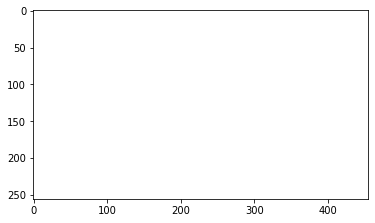

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

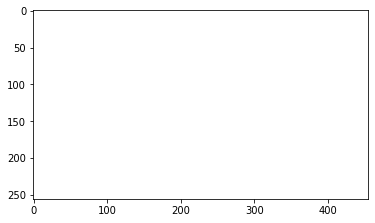

In [12]:
############################################################
#################test code#################################
############################################################
############################################################
############################################################
data_dir='data/KingsCollege/'
datasource = DataSource(data_dir, train=False)
image,data = datasource.__getitem__(3)
# print(torch.tensor(data))
# import matplotlib.pyplot as plt

# image = image.permute(1, 2, 0)
# print(image)
# plt.imshow(image)
# # img = Image.fromarray(image, 'RGB')
# # img.save("temp1.png")
# # img.show()

# Part 6: Experiments

## Step 1: Training

In [6]:
import torch
import numpy as np
import torch.utils.data as Data
import torch.nn as nn
from torch.autograd import Variable
# from models.PoseNet import PoseNet, PoseLoss
# from data.DataSource import *
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(epochs, batch_size, learning_rate, save_freq, data_dir):
    # train dataset and train loader
    datasource = DataSource(data_dir, train=True)
    train_loader = Data.DataLoader(dataset=datasource, batch_size=batch_size, shuffle=False)

    # load model
    posenet = PoseNet().to(device)

    # loss function
    criterion = PoseLoss(0.3, 0.3, 1., 300, 300, 300)

    # train the network
    optimizer = torch.optim.Adam(nn.ParameterList(posenet.parameters()),
                     lr=learning_rate, eps=1,
                     weight_decay=0.0625,
                     betas=(0.9, 0.999))

    batches_per_epoch = len(train_loader.batch_sampler)
    avg_loss_epoch = []
    for epoch in range(epochs):
        print("Starting epoch {}:".format(epoch))
        posenet.train()
        total_loss = 0
        for step, (images, poses) in enumerate(train_loader):
            # print(images.size())
            b_images = Variable(images, requires_grad=True).to(device)
#             print(poses)
            poses[0] = np.array(poses[0])
            poses[1] = np.array(poses[1])
        # torch.save(posenet.state_dict(), save_path)
        # print("Network saved!")

            poses[2] = np.array(poses[2])
            poses[3] = np.array(poses[3])
            poses[4] = np.array(poses[4])
            poses[5] = np.array(poses[5])
            poses[6] = np.array(poses[6])
            poses = np.transpose(poses)
   
            b_poses = Variable(torch.Tensor(poses), requires_grad=True).to(device)
            # print(b_images.size())
            p1_x, p1_q, p2_x, p2_q, p3_x, p3_q = posenet(b_images)
#             print(p1_x)
#             print(p1_q)
#             print(p2_x)
#             print(p2_q)
#             print(p3_x)
#             print(p3_q)
#             print(b_poses)
            loss = criterion(p1_x, p1_q, p2_x, p2_q, p3_x, p3_q, b_poses)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print("{}/{}: loss = {}".format(step+1, batches_per_epoch, loss))
        avg_loss = total_loss / batches_per_epoch
        avg_loss_epoch.append(avg_loss)
        print("Average loss for epoch{}: {}".format(epoch, avg_loss))
        # Save state
        if epoch % save_freq == 0:
            save_filename = 'epoch_{}.pth'.format(str(epoch+1).zfill(5))
            save_path = os.path.join('checkpoints', save_filename)
            torch.save(posenet.state_dict(), save_path)
    return avg_loss_epoch


In [8]:
torch.cuda.empty_cache()

In [13]:
# Fill the hyperparameters with proper values
epochs=161
batch_size=8
learning_rate=0.0001
save_freq=20
data_dir='data/KingsCollege/'
train_loss = train(epochs, batch_size, learning_rate, save_freq, data_dir)


Mean image loaded!
Loading pretrained InceptionV1 weights...
PoseNet model created!
Starting epoch 0:
1/153: loss = 383.1152648925781
2/153: loss = 326.37847900390625
3/153: loss = 269.01287841796875
4/153: loss = 244.0101318359375
5/153: loss = 290.9857482910156
6/153: loss = 359.448486328125
7/153: loss = 323.00872802734375
8/153: loss = 249.67233276367188
9/153: loss = 201.57347106933594
10/153: loss = 225.3778076171875
11/153: loss = 416.3268737792969
12/153: loss = 234.20587158203125
13/153: loss = 237.80361938476562
14/153: loss = 394.57891845703125
15/153: loss = 473.3689270019531
16/153: loss = 523.1083374023438
17/153: loss = 286.0937805175781
18/153: loss = 288.70098876953125
19/153: loss = 376.033935546875
20/153: loss = 399.5664367675781
21/153: loss = 430.8421325683594
22/153: loss = 349.8914489746094
23/153: loss = 306.75299072265625
24/153: loss = 345.0321350097656
25/153: loss = 291.56817626953125
26/153: loss = 258.92169189453125
27/153: loss = 372.6651611328125
28/153

92/153: loss = 490.1011047363281
93/153: loss = 258.539306640625
94/153: loss = 277.92913818359375
95/153: loss = 384.86956787109375
96/153: loss = 465.9892272949219
97/153: loss = 397.416748046875
98/153: loss = 223.01187133789062
99/153: loss = 163.43377685546875
100/153: loss = 174.58106994628906
101/153: loss = 188.87039184570312
102/153: loss = 200.95419311523438
103/153: loss = 145.36827087402344
104/153: loss = 118.7542724609375
105/153: loss = 110.67550659179688
106/153: loss = 88.96976470947266
107/153: loss = 143.27923583984375
108/153: loss = 110.10104370117188
109/153: loss = 156.33407592773438
110/153: loss = 220.19158935546875
111/153: loss = 192.9829864501953
112/153: loss = 181.08071899414062
113/153: loss = 189.82952880859375
114/153: loss = 324.62689208984375
115/153: loss = 486.0132141113281
116/153: loss = 570.46142578125
117/153: loss = 663.8869018554688
118/153: loss = 667.2808837890625
119/153: loss = 747.1973876953125
120/153: loss = 867.8592529296875
121/153: l

31/153: loss = 558.82666015625
32/153: loss = 488.05133056640625
33/153: loss = 291.3089599609375
34/153: loss = 1175.634521484375
35/153: loss = 576.2813720703125
36/153: loss = 82.92300415039062
37/153: loss = 91.31916809082031
38/153: loss = 383.52923583984375
39/153: loss = 811.8453369140625
40/153: loss = 967.8353271484375
41/153: loss = 1290.6630859375
42/153: loss = 1272.812744140625
43/153: loss = 982.003662109375
44/153: loss = 671.2357177734375
45/153: loss = 56.5032958984375
46/153: loss = 50.73630142211914
47/153: loss = 317.2161865234375
48/153: loss = 348.26470947265625
49/153: loss = 594.3668212890625
50/153: loss = 353.1007080078125
51/153: loss = 337.81951904296875
52/153: loss = 444.6924133300781
53/153: loss = 453.76702880859375
54/153: loss = 403.277587890625
55/153: loss = 495.3669738769531
56/153: loss = 320.87921142578125
57/153: loss = 277.2430419921875
58/153: loss = 401.908203125
59/153: loss = 770.9475708007812
60/153: loss = 587.2456665039062
61/153: loss = 

125/153: loss = 541.3629760742188
126/153: loss = 558.6190795898438
127/153: loss = 699.6945190429688
128/153: loss = 794.389404296875
129/153: loss = 833.2400512695312
130/153: loss = 1016.8717041015625
131/153: loss = 1118.7755126953125
132/153: loss = 1432.602294921875
133/153: loss = 1452.09521484375
134/153: loss = 1338.179443359375
135/153: loss = 959.8194580078125
136/153: loss = 586.5151977539062
137/153: loss = 1359.210205078125
138/153: loss = 1400.699951171875
139/153: loss = 1604.0408935546875
140/153: loss = 1776.41162109375
141/153: loss = 1964.68798828125
142/153: loss = 2053.280029296875
143/153: loss = 2255.38330078125
144/153: loss = 2588.181640625
145/153: loss = 2971.13525390625
146/153: loss = 2797.28857421875
147/153: loss = 2265.234130859375
148/153: loss = 3061.65673828125
149/153: loss = 2475.850341796875
150/153: loss = 3171.7548828125
151/153: loss = 3141.908935546875
152/153: loss = 1417.8809814453125
153/153: loss = 1113.33056640625
Average loss for epoch4:

65/153: loss = 493.62335205078125
66/153: loss = 565.6634521484375
67/153: loss = 648.3896484375
68/153: loss = 727.8348388671875
69/153: loss = 761.5360717773438
70/153: loss = 844.4682006835938
71/153: loss = 866.17578125
72/153: loss = 909.98388671875
73/153: loss = 844.7562866210938
74/153: loss = 796.5618286132812
75/153: loss = 714.9210205078125
76/153: loss = 889.2271118164062
77/153: loss = 1048.4423828125
78/153: loss = 949.21728515625
79/153: loss = 984.0955810546875
80/153: loss = 969.3956909179688
81/153: loss = 1107.4080810546875
82/153: loss = 1271.403076171875
83/153: loss = 1345.26318359375
84/153: loss = 1563.2138671875
85/153: loss = 1134.13427734375
86/153: loss = 1968.89501953125
87/153: loss = 2167.29248046875
88/153: loss = 2372.19287109375
89/153: loss = 2651.75048828125
90/153: loss = 2916.375
91/153: loss = 2530.777587890625
92/153: loss = 332.73223876953125
93/153: loss = 327.1734619140625
94/153: loss = 352.79498291015625
95/153: loss = 572.0145874023438
96/1

4/153: loss = 1292.2391357421875
5/153: loss = 681.9686279296875
6/153: loss = 783.3558349609375
7/153: loss = 443.82452392578125
8/153: loss = 255.14749145507812
9/153: loss = 152.72665405273438
10/153: loss = 164.12110900878906
11/153: loss = 631.4007568359375
12/153: loss = 219.0429229736328
13/153: loss = 124.82722473144531
14/153: loss = 204.24932861328125
15/153: loss = 298.7810363769531
16/153: loss = 341.64306640625
17/153: loss = 200.81141662597656
18/153: loss = 151.96925354003906
19/153: loss = 234.9996337890625
20/153: loss = 229.06568908691406
21/153: loss = 256.00244140625
22/153: loss = 205.28253173828125
23/153: loss = 169.95404052734375
24/153: loss = 192.6452178955078
25/153: loss = 213.9601593017578
26/153: loss = 258.47265625
27/153: loss = 191.80589294433594
28/153: loss = 570.7579345703125
29/153: loss = 493.4658508300781
30/153: loss = 405.7145080566406
31/153: loss = 588.5799560546875
32/153: loss = 573.8950805664062
33/153: loss = 216.97726440429688
34/153: los

98/153: loss = 185.2462158203125
99/153: loss = 113.00785827636719
100/153: loss = 86.84197998046875
101/153: loss = 66.68506622314453
102/153: loss = 90.02641296386719
103/153: loss = 76.94218444824219
104/153: loss = 114.61955261230469
105/153: loss = 107.10853576660156
106/153: loss = 96.77662658691406
107/153: loss = 113.44660949707031
108/153: loss = 73.02571105957031
109/153: loss = 58.274330139160156
110/153: loss = 78.39205932617188
111/153: loss = 71.2840347290039
112/153: loss = 60.561927795410156
113/153: loss = 63.43522262573242
114/153: loss = 85.75175476074219
115/153: loss = 547.39990234375
116/153: loss = 697.3584594726562
117/153: loss = 732.0372924804688
118/153: loss = 732.181884765625
119/153: loss = 770.6318359375
120/153: loss = 861.4296264648438
121/153: loss = 545.6217651367188
122/153: loss = 871.8753662109375
123/153: loss = 178.46437072753906
124/153: loss = 196.10189819335938
125/153: loss = 262.6317443847656
126/153: loss = 251.92715454101562
127/153: loss 

37/153: loss = 50.269554138183594
38/153: loss = 328.9997863769531
39/153: loss = 690.6005859375
40/153: loss = 720.750732421875
41/153: loss = 1038.0262451171875
42/153: loss = 1041.760986328125
43/153: loss = 769.14306640625
44/153: loss = 538.4072265625
45/153: loss = 105.65443420410156
46/153: loss = 101.06080627441406
47/153: loss = 289.84918212890625
48/153: loss = 431.5101623535156
49/153: loss = 450.89892578125
50/153: loss = 414.293701171875
51/153: loss = 495.1004333496094
52/153: loss = 626.8124389648438
53/153: loss = 631.4349365234375
54/153: loss = 561.321533203125
55/153: loss = 685.4583129882812
56/153: loss = 470.4077453613281
57/153: loss = 401.5589294433594
58/153: loss = 469.08526611328125
59/153: loss = 635.97021484375
60/153: loss = 649.7313232421875
61/153: loss = 293.5658264160156
62/153: loss = 494.2295837402344
63/153: loss = 516.048095703125
64/153: loss = 728.0890502929688
65/153: loss = 525.3964233398438
66/153: loss = 720.768798828125
67/153: loss = 830.82

130/153: loss = 271.383056640625
131/153: loss = 930.078857421875
132/153: loss = 1181.005126953125
133/153: loss = 1213.1279296875
134/153: loss = 937.25732421875
135/153: loss = 226.4495391845703
136/153: loss = 257.06549072265625
137/153: loss = 216.72412109375
138/153: loss = 372.2052001953125
139/153: loss = 254.29579162597656
140/153: loss = 433.77520751953125
141/153: loss = 467.87969970703125
142/153: loss = 407.2150573730469
143/153: loss = 392.6343994140625
144/153: loss = 373.0157165527344
145/153: loss = 414.17572021484375
146/153: loss = 547.3873291015625
147/153: loss = 258.0185546875
148/153: loss = 688.5591430664062
149/153: loss = 367.7007751464844
150/153: loss = 596.61376953125
151/153: loss = 353.7007141113281
152/153: loss = 415.9312438964844
153/153: loss = 309.91217041015625
Average loss for epoch12: 469.76946851942273
Starting epoch 13:
1/153: loss = 585.8948974609375
2/153: loss = 834.3275756835938
3/153: loss = 1229.8494873046875
4/153: loss = 1914.36059570312

67/153: loss = 709.023193359375
68/153: loss = 647.748046875
69/153: loss = 699.86572265625
70/153: loss = 557.5927734375
71/153: loss = 637.8524169921875
72/153: loss = 368.16351318359375
73/153: loss = 466.04736328125
74/153: loss = 298.74151611328125
75/153: loss = 342.46759033203125
76/153: loss = 598.7261962890625
77/153: loss = 381.364501953125
78/153: loss = 322.8791809082031
79/153: loss = 316.3740234375
80/153: loss = 217.08843994140625
81/153: loss = 160.33255004882812
82/153: loss = 247.12368774414062
83/153: loss = 215.44424438476562
84/153: loss = 125.25736999511719
85/153: loss = 173.70748901367188
86/153: loss = 242.91925048828125
87/153: loss = 251.58938598632812
88/153: loss = 482.67449951171875
89/153: loss = 507.4321594238281
90/153: loss = 796.7646484375
91/153: loss = 585.0614013671875
92/153: loss = 190.83177185058594
93/153: loss = 162.94125366210938
94/153: loss = 147.8069610595703
95/153: loss = 214.8719482421875
96/153: loss = 290.3897705078125
97/153: loss = 

3/153: loss = 543.6416015625
4/153: loss = 1031.693115234375
5/153: loss = 266.9359130859375
6/153: loss = 413.58282470703125
7/153: loss = 204.93756103515625
8/153: loss = 140.2074737548828
9/153: loss = 110.90959167480469
10/153: loss = 133.10572814941406
11/153: loss = 614.982177734375
12/153: loss = 146.9195556640625
13/153: loss = 68.6754150390625
14/153: loss = 96.71183776855469
15/153: loss = 107.42709350585938
16/153: loss = 137.1842498779297
17/153: loss = 78.01652526855469
18/153: loss = 50.85435485839844
19/153: loss = 88.06356811523438
20/153: loss = 112.25798034667969
21/153: loss = 138.85372924804688
22/153: loss = 94.98968505859375
23/153: loss = 84.61515808105469
24/153: loss = 90.21804809570312
25/153: loss = 129.47244262695312
26/153: loss = 156.18894958496094
27/153: loss = 103.72895812988281
28/153: loss = 895.5755615234375
29/153: loss = 376.9951171875
30/153: loss = 273.88409423828125
31/153: loss = 461.1462097167969
32/153: loss = 476.23699951171875
33/153: loss 

94/153: loss = 76.26777648925781
95/153: loss = 107.5788345336914
96/153: loss = 160.23361206054688
97/153: loss = 165.52474975585938
98/153: loss = 55.897682189941406
99/153: loss = 56.27953338623047
100/153: loss = 83.46322631835938
101/153: loss = 72.15019989013672
102/153: loss = 76.07353210449219
103/153: loss = 54.547935485839844
104/153: loss = 72.9726791381836
105/153: loss = 48.34791946411133
106/153: loss = 61.19615173339844
107/153: loss = 21.386981964111328
108/153: loss = 33.300933837890625
109/153: loss = 47.80079650878906
110/153: loss = 35.64829635620117
111/153: loss = 49.971763610839844
112/153: loss = 101.24800109863281
113/153: loss = 71.3411865234375
114/153: loss = 113.17019653320312
115/153: loss = 158.78631591796875
116/153: loss = 258.06585693359375
117/153: loss = 293.3823547363281
118/153: loss = 321.91064453125
119/153: loss = 329.5403747558594
120/153: loss = 405.88519287109375
121/153: loss = 240.60633850097656
122/153: loss = 430.7845458984375
123/153: lo

30/153: loss = 285.43756103515625
31/153: loss = 365.9740905761719
32/153: loss = 296.72833251953125
33/153: loss = 108.40875244140625
34/153: loss = 908.65966796875
35/153: loss = 207.02853393554688
36/153: loss = 19.601516723632812
37/153: loss = 25.536087036132812
38/153: loss = 258.92828369140625
39/153: loss = 675.6653442382812
40/153: loss = 424.59661865234375
41/153: loss = 640.4526977539062
42/153: loss = 672.3759765625
43/153: loss = 593.1387939453125
44/153: loss = 341.8084411621094
45/153: loss = 171.5908203125
46/153: loss = 213.52850341796875
47/153: loss = 215.41754150390625
48/153: loss = 342.18292236328125
49/153: loss = 239.37684631347656
50/153: loss = 298.0931701660156
51/153: loss = 506.6698913574219
52/153: loss = 636.979248046875
53/153: loss = 656.033203125
54/153: loss = 545.3743896484375
55/153: loss = 512.60986328125
56/153: loss = 285.7698669433594
57/153: loss = 183.77651977539062
58/153: loss = 229.3916015625
59/153: loss = 360.942626953125
60/153: loss = 2

121/153: loss = 122.98320007324219
122/153: loss = 288.5893249511719
123/153: loss = 47.08969497680664
124/153: loss = 58.816795349121094
125/153: loss = 60.61942672729492
126/153: loss = 68.0123062133789
127/153: loss = 115.89630126953125
128/153: loss = 119.31547546386719
129/153: loss = 103.11114501953125
130/153: loss = 124.50193786621094
131/153: loss = 346.9428405761719
132/153: loss = 459.26885986328125
133/153: loss = 453.254638671875
134/153: loss = 388.0931396484375
135/153: loss = 175.87030029296875
136/153: loss = 104.81535339355469
137/153: loss = 100.1092529296875
138/153: loss = 119.51506042480469
139/153: loss = 166.85186767578125
140/153: loss = 123.1468505859375
141/153: loss = 95.22962951660156
142/153: loss = 162.642822265625
143/153: loss = 134.0086669921875
144/153: loss = 120.33322143554688
145/153: loss = 272.10107421875
146/153: loss = 261.437744140625
147/153: loss = 125.12527465820312
148/153: loss = 252.15859985351562
149/153: loss = 104.38633728027344
150/1

55/153: loss = 194.3940887451172
56/153: loss = 64.53338623046875
57/153: loss = 44.7012939453125
58/153: loss = 157.25341796875
59/153: loss = 324.89117431640625
60/153: loss = 132.11485290527344
61/153: loss = 176.1752471923828
62/153: loss = 287.1451416015625
63/153: loss = 268.4905700683594
64/153: loss = 475.08087158203125
65/153: loss = 227.8744659423828
66/153: loss = 103.34130859375
67/153: loss = 183.05264282226562
68/153: loss = 134.95916748046875
69/153: loss = 59.36997604370117
70/153: loss = 99.30046081542969
71/153: loss = 75.6971435546875
72/153: loss = 186.7984619140625
73/153: loss = 41.917564392089844
74/153: loss = 125.00486755371094
75/153: loss = 103.14205169677734
76/153: loss = 109.02043151855469
77/153: loss = 74.06575012207031
78/153: loss = 65.25848388671875
79/153: loss = 68.77510070800781
80/153: loss = 82.25952911376953
81/153: loss = 48.27662658691406
82/153: loss = 74.31877136230469
83/153: loss = 59.22422790527344
84/153: loss = 112.58598327636719
85/153

144/153: loss = 196.22491455078125
145/153: loss = 100.82939147949219
146/153: loss = 79.47906494140625
147/153: loss = 151.38473510742188
148/153: loss = 520.549072265625
149/153: loss = 232.09292602539062
150/153: loss = 412.32879638671875
151/153: loss = 180.58792114257812
152/153: loss = 100.59376525878906
153/153: loss = 51.255821228027344
Average loss for epoch23: 129.98234878490175
Starting epoch 24:
1/153: loss = 159.918212890625
2/153: loss = 299.2511901855469
3/153: loss = 193.45309448242188
4/153: loss = 180.72219848632812
5/153: loss = 31.786052703857422
6/153: loss = 77.19400024414062
7/153: loss = 35.534278869628906
8/153: loss = 53.87737274169922
9/153: loss = 53.63455581665039
10/153: loss = 69.50679016113281
11/153: loss = 233.90966796875
12/153: loss = 54.41080093383789
13/153: loss = 89.77472686767578
14/153: loss = 128.18789672851562
15/153: loss = 265.8644104003906
16/153: loss = 213.4658203125
17/153: loss = 94.88993835449219
18/153: loss = 74.8899154663086
19/153

79/153: loss = 75.28669738769531
80/153: loss = 50.359832763671875
81/153: loss = 41.597755432128906
82/153: loss = 59.692230224609375
83/153: loss = 73.90591430664062
84/153: loss = 73.94346618652344
85/153: loss = 56.1036376953125
86/153: loss = 113.91067504882812
87/153: loss = 97.31510925292969
88/153: loss = 79.43098449707031
89/153: loss = 100.28955078125
90/153: loss = 233.28042602539062
91/153: loss = 334.9749755859375
92/153: loss = 169.1852264404297
93/153: loss = 192.10159301757812
94/153: loss = 171.78794860839844
95/153: loss = 128.38394165039062
96/153: loss = 77.79520416259766
97/153: loss = 94.57241821289062
98/153: loss = 128.99539184570312
99/153: loss = 100.8387680053711
100/153: loss = 91.62985229492188
101/153: loss = 53.44810485839844
102/153: loss = 60.25800704956055
103/153: loss = 38.09867858886719
104/153: loss = 22.734086990356445
105/153: loss = 33.014007568359375
106/153: loss = 27.004085540771484
107/153: loss = 27.692981719970703
108/153: loss = 11.781895

13/153: loss = 60.352149963378906
14/153: loss = 66.61896514892578
15/153: loss = 76.09036254882812
16/153: loss = 48.962486267089844
17/153: loss = 44.74604797363281
18/153: loss = 24.522769927978516
19/153: loss = 25.62503433227539
20/153: loss = 35.252235412597656
21/153: loss = 52.300933837890625
22/153: loss = 24.27544593811035
23/153: loss = 49.8824462890625
24/153: loss = 48.47303771972656
25/153: loss = 44.47447967529297
26/153: loss = 52.564247131347656
27/153: loss = 22.80486297607422
28/153: loss = 101.36634826660156
29/153: loss = 48.25993347167969
30/153: loss = 42.84992980957031
31/153: loss = 90.58893585205078
32/153: loss = 121.8720703125
33/153: loss = 39.396629333496094
34/153: loss = 124.90388488769531
35/153: loss = 33.77912521362305
36/153: loss = 93.8304214477539
37/153: loss = 47.038909912109375
38/153: loss = 57.79261016845703
39/153: loss = 217.77731323242188
40/153: loss = 79.41975402832031
41/153: loss = 111.90142822265625
42/153: loss = 94.91189575195312
43/

103/153: loss = 21.089454650878906
104/153: loss = 24.89260482788086
105/153: loss = 40.85053253173828
106/153: loss = 44.81354522705078
107/153: loss = 29.213537216186523
108/153: loss = 24.0567684173584
109/153: loss = 10.458647727966309
110/153: loss = 17.732696533203125
111/153: loss = 39.041866302490234
112/153: loss = 24.78432846069336
113/153: loss = 25.658924102783203
114/153: loss = 37.685062408447266
115/153: loss = 67.19847869873047
116/153: loss = 26.146881103515625
117/153: loss = 23.02119255065918
118/153: loss = 41.713050842285156
119/153: loss = 45.368709564208984
120/153: loss = 103.4913558959961
121/153: loss = 42.57071304321289
122/153: loss = 85.2476806640625
123/153: loss = 43.690513610839844
124/153: loss = 47.72443389892578
125/153: loss = 20.54545783996582
126/153: loss = 21.095088958740234
127/153: loss = 34.017494201660156
128/153: loss = 33.23478698730469
129/153: loss = 21.4632568359375
130/153: loss = 48.392051696777344
131/153: loss = 143.329345703125
132/

37/153: loss = 49.07098388671875
38/153: loss = 29.90625
39/153: loss = 87.76817321777344
40/153: loss = 80.423828125
41/153: loss = 56.2083854675293
42/153: loss = 36.22674560546875
43/153: loss = 74.12773132324219
44/153: loss = 73.228515625
45/153: loss = 27.24420166015625
46/153: loss = 63.002357482910156
47/153: loss = 51.581356048583984
48/153: loss = 61.68817901611328
49/153: loss = 28.553489685058594
50/153: loss = 25.265670776367188
51/153: loss = 19.53520965576172
52/153: loss = 27.45830535888672
53/153: loss = 62.907867431640625
54/153: loss = 59.38822937011719
55/153: loss = 55.04826736450195
56/153: loss = 37.059303283691406
57/153: loss = 14.836701393127441
58/153: loss = 40.991477966308594
59/153: loss = 92.85226440429688
60/153: loss = 45.77690505981445
61/153: loss = 51.0007438659668
62/153: loss = 58.16365051269531
63/153: loss = 165.11932373046875
64/153: loss = 91.3539810180664
65/153: loss = 65.25737762451172
66/153: loss = 36.15399169921875
67/153: loss = 39.56245

128/153: loss = 52.345069885253906
129/153: loss = 33.89476013183594
130/153: loss = 48.335548400878906
131/153: loss = 76.34536743164062
132/153: loss = 126.36063385009766
133/153: loss = 112.07290649414062
134/153: loss = 109.19515991210938
135/153: loss = 52.302433013916016
136/153: loss = 96.9490966796875
137/153: loss = 49.6154670715332
138/153: loss = 80.80371856689453
139/153: loss = 78.94029235839844
140/153: loss = 100.46131896972656
141/153: loss = 72.27572631835938
142/153: loss = 99.50527954101562
143/153: loss = 72.39566040039062
144/153: loss = 78.3037338256836
145/153: loss = 83.7630615234375
146/153: loss = 139.78164672851562
147/153: loss = 50.76045608520508
148/153: loss = 106.53370666503906
149/153: loss = 64.96190643310547
150/153: loss = 157.1728973388672
151/153: loss = 108.9678955078125
152/153: loss = 130.19558715820312
153/153: loss = 184.19540405273438
Average loss for epoch31: 60.407858948302426
Starting epoch 32:
1/153: loss = 32.760807037353516
2/153: loss 

63/153: loss = 120.90213012695312
64/153: loss = 66.62593078613281
65/153: loss = 27.432552337646484
66/153: loss = 25.044845581054688
67/153: loss = 28.585941314697266
68/153: loss = 32.56719970703125
69/153: loss = 43.953006744384766
70/153: loss = 21.214523315429688
71/153: loss = 51.7161979675293
72/153: loss = 20.448383331298828
73/153: loss = 45.03630828857422
74/153: loss = 29.834388732910156
75/153: loss = 34.763648986816406
76/153: loss = 54.37813949584961
77/153: loss = 46.509422302246094
78/153: loss = 50.269710540771484
79/153: loss = 40.879661560058594
80/153: loss = 38.415565490722656
81/153: loss = 28.117097854614258
82/153: loss = 45.80634307861328
83/153: loss = 42.26445007324219
84/153: loss = 47.0634765625
85/153: loss = 61.943931579589844
86/153: loss = 47.944297790527344
87/153: loss = 26.291637420654297
88/153: loss = 66.78897094726562
89/153: loss = 123.44819641113281
90/153: loss = 121.12816619873047
91/153: loss = 88.86738586425781
92/153: loss = 41.86557769775

151/153: loss = 141.69696044921875
152/153: loss = 79.97953796386719
153/153: loss = 160.093505859375
Average loss for epoch34: 47.99302948845757
Starting epoch 35:
1/153: loss = 25.545352935791016
2/153: loss = 28.329936981201172
3/153: loss = 28.925540924072266
4/153: loss = 23.536941528320312
5/153: loss = 10.584599494934082
6/153: loss = 13.762393951416016
7/153: loss = 19.91495704650879
8/153: loss = 11.397260665893555
9/153: loss = 13.289031982421875
10/153: loss = 18.27939224243164
11/153: loss = 52.52983093261719
12/153: loss = 14.763985633850098
13/153: loss = 34.338043212890625
14/153: loss = 31.3370361328125
15/153: loss = 34.0177116394043
16/153: loss = 21.607006072998047
17/153: loss = 23.859766006469727
18/153: loss = 17.21063804626465
19/153: loss = 13.191210746765137
20/153: loss = 9.72128963470459
21/153: loss = 18.221420288085938
22/153: loss = 14.671720504760742
23/153: loss = 13.312895774841309
24/153: loss = 13.832197189331055
25/153: loss = 19.429967880249023
26/1

86/153: loss = 44.353187561035156
87/153: loss = 51.855003356933594
88/153: loss = 64.84355163574219
89/153: loss = 123.51264953613281
90/153: loss = 90.18787384033203
91/153: loss = 78.36078643798828
92/153: loss = 41.577728271484375
93/153: loss = 23.322612762451172
94/153: loss = 31.775850296020508
95/153: loss = 46.90339660644531
96/153: loss = 59.94454574584961
97/153: loss = 42.78955078125
98/153: loss = 36.78382873535156
99/153: loss = 28.736106872558594
100/153: loss = 24.933521270751953
101/153: loss = 20.061994552612305
102/153: loss = 27.458332061767578
103/153: loss = 19.395549774169922
104/153: loss = 10.789051055908203
105/153: loss = 18.173200607299805
106/153: loss = 17.177162170410156
107/153: loss = 11.62887191772461
108/153: loss = 18.482959747314453
109/153: loss = 13.670241355895996
110/153: loss = 7.871289253234863
111/153: loss = 13.522422790527344
112/153: loss = 19.0075740814209
113/153: loss = 28.72519874572754
114/153: loss = 39.54736328125
115/153: loss = 34

19/153: loss = 17.473854064941406
20/153: loss = 16.958805084228516
21/153: loss = 13.159958839416504
22/153: loss = 16.834327697753906
23/153: loss = 17.94538116455078
24/153: loss = 14.029598236083984
25/153: loss = 21.75143051147461
26/153: loss = 22.217098236083984
27/153: loss = 13.809541702270508
28/153: loss = 40.03466796875
29/153: loss = 38.84917449951172
30/153: loss = 24.309551239013672
31/153: loss = 40.06747055053711
32/153: loss = 42.11924743652344
33/153: loss = 29.267955780029297
34/153: loss = 54.867431640625
35/153: loss = 28.405424118041992
36/153: loss = 12.507617950439453
37/153: loss = 11.697033882141113
38/153: loss = 17.402790069580078
39/153: loss = 46.66389083862305
40/153: loss = 35.12408447265625
41/153: loss = 44.91157531738281
42/153: loss = 30.78112030029297
43/153: loss = 34.84154510498047
44/153: loss = 29.697410583496094
45/153: loss = 22.535552978515625
46/153: loss = 41.87870407104492
47/153: loss = 25.410770416259766
48/153: loss = 17.05531120300293

109/153: loss = 12.566272735595703
110/153: loss = 15.930793762207031
111/153: loss = 13.363998413085938
112/153: loss = 18.18327522277832
113/153: loss = 29.99404525756836
114/153: loss = 28.18204116821289
115/153: loss = 39.9684944152832
116/153: loss = 29.95724105834961
117/153: loss = 15.7145357131958
118/153: loss = 28.061370849609375
119/153: loss = 26.025836944580078
120/153: loss = 29.641803741455078
121/153: loss = 70.40715026855469
122/153: loss = 35.41925811767578
123/153: loss = 45.10020065307617
124/153: loss = 31.92824935913086
125/153: loss = 37.239742279052734
126/153: loss = 18.441608428955078
127/153: loss = 46.84968566894531
128/153: loss = 21.743221282958984
129/153: loss = 28.651565551757812
130/153: loss = 54.71588134765625
131/153: loss = 59.805572509765625
132/153: loss = 72.79940032958984
133/153: loss = 71.72075653076172
134/153: loss = 77.48882293701172
135/153: loss = 47.92081069946289
136/153: loss = 51.94268798828125
137/153: loss = 65.95157623291016
138/1

43/153: loss = 39.78472900390625
44/153: loss = 56.41907501220703
45/153: loss = 21.92151641845703
46/153: loss = 22.56573486328125
47/153: loss = 33.19758987426758
48/153: loss = 30.819320678710938
49/153: loss = 32.703086853027344
50/153: loss = 21.92333984375
51/153: loss = 19.472366333007812
52/153: loss = 18.993602752685547
53/153: loss = 15.947406768798828
54/153: loss = 20.181896209716797
55/153: loss = 14.752435684204102
56/153: loss = 16.017723083496094
57/153: loss = 12.875606536865234
58/153: loss = 17.797222137451172
59/153: loss = 43.61894989013672
60/153: loss = 50.37830352783203
61/153: loss = 51.13416290283203
62/153: loss = 43.54358673095703
63/153: loss = 46.284690856933594
64/153: loss = 60.912872314453125
65/153: loss = 30.342910766601562
66/153: loss = 20.258270263671875
67/153: loss = 37.35235595703125
68/153: loss = 22.425949096679688
69/153: loss = 25.403743743896484
70/153: loss = 68.75688171386719
71/153: loss = 36.17886734008789
72/153: loss = 44.985897064208

132/153: loss = 97.84132385253906
133/153: loss = 120.19180297851562
134/153: loss = 80.69967651367188
135/153: loss = 25.242082595825195
136/153: loss = 77.69293212890625
137/153: loss = 56.620201110839844
138/153: loss = 45.731651306152344
139/153: loss = 28.900981903076172
140/153: loss = 39.81663131713867
141/153: loss = 49.31243896484375
142/153: loss = 44.332523345947266
143/153: loss = 42.00685119628906
144/153: loss = 52.14739227294922
145/153: loss = 47.75929260253906
146/153: loss = 79.99180603027344
147/153: loss = 56.60764694213867
148/153: loss = 77.78997039794922
149/153: loss = 39.85826873779297
150/153: loss = 38.111549377441406
151/153: loss = 64.26896667480469
152/153: loss = 63.54480743408203
153/153: loss = 96.32986450195312
Average loss for epoch42: 37.026274777705375
Starting epoch 43:
1/153: loss = 18.308734893798828
2/153: loss = 34.34125518798828
3/153: loss = 26.112192153930664
4/153: loss = 17.50652503967285
5/153: loss = 13.76083755493164
6/153: loss = 12.09

66/153: loss = 15.081781387329102
67/153: loss = 18.394372940063477
68/153: loss = 22.608665466308594
69/153: loss = 14.575578689575195
70/153: loss = 33.947669982910156
71/153: loss = 16.448871612548828
72/153: loss = 19.512210845947266
73/153: loss = 21.929922103881836
74/153: loss = 19.597183227539062
75/153: loss = 18.22937774658203
76/153: loss = 27.080711364746094
77/153: loss = 20.539939880371094
78/153: loss = 33.17823791503906
79/153: loss = 29.890153884887695
80/153: loss = 51.51753234863281
81/153: loss = 39.85700225830078
82/153: loss = 26.240768432617188
83/153: loss = 49.77532958984375
84/153: loss = 33.66313171386719
85/153: loss = 37.20856475830078
86/153: loss = 40.55219268798828
87/153: loss = 36.97425842285156
88/153: loss = 53.60746383666992
89/153: loss = 81.0628662109375
90/153: loss = 114.98538208007812
91/153: loss = 70.37025451660156
92/153: loss = 17.846275329589844
93/153: loss = 9.868875503540039
94/153: loss = 29.780101776123047
95/153: loss = 40.5245018005

1/153: loss = 15.545741081237793
2/153: loss = 19.44580078125
3/153: loss = 14.252731323242188
4/153: loss = 13.555679321289062
5/153: loss = 13.693647384643555
6/153: loss = 19.113693237304688
7/153: loss = 21.721017837524414
8/153: loss = 13.530799865722656
9/153: loss = 17.89777374267578
10/153: loss = 21.82742691040039
11/153: loss = 23.281993865966797
12/153: loss = 11.541326522827148
13/153: loss = 15.791024208068848
14/153: loss = 46.06810760498047
15/153: loss = 28.135393142700195
16/153: loss = 41.631431579589844
17/153: loss = 11.85594367980957
18/153: loss = 7.885834693908691
19/153: loss = 10.320542335510254
20/153: loss = 8.986889839172363
21/153: loss = 11.918327331542969
22/153: loss = 13.403189659118652
23/153: loss = 8.115260124206543
24/153: loss = 18.174144744873047
25/153: loss = 22.617210388183594
26/153: loss = 25.862873077392578
27/153: loss = 12.779402732849121
28/153: loss = 89.84910583496094
29/153: loss = 15.491596221923828
30/153: loss = 11.059052467346191
3

90/153: loss = 112.40653991699219
91/153: loss = 74.11067199707031
92/153: loss = 37.66444396972656
93/153: loss = 7.358685493469238
94/153: loss = 31.32646942138672
95/153: loss = 61.796485900878906
96/153: loss = 39.57566833496094
97/153: loss = 30.792442321777344
98/153: loss = 47.958229064941406
99/153: loss = 39.69657897949219
100/153: loss = 29.509628295898438
101/153: loss = 21.083898544311523
102/153: loss = 29.452919006347656
103/153: loss = 8.06712818145752
104/153: loss = 11.715920448303223
105/153: loss = 12.55937385559082
106/153: loss = 13.362363815307617
107/153: loss = 12.77206039428711
108/153: loss = 14.232772827148438
109/153: loss = 11.665759086608887
110/153: loss = 9.184517860412598
111/153: loss = 11.199653625488281
112/153: loss = 21.614789962768555
113/153: loss = 28.283855438232422
114/153: loss = 47.155372619628906
115/153: loss = 45.28822326660156
116/153: loss = 72.80640411376953
117/153: loss = 82.23704528808594
118/153: loss = 29.544692993164062
119/153: 

23/153: loss = 6.575044631958008
24/153: loss = 11.737592697143555
25/153: loss = 24.140838623046875
26/153: loss = 23.01015853881836
27/153: loss = 10.603632926940918
28/153: loss = 22.945903778076172
29/153: loss = 19.39649772644043
30/153: loss = 9.200006484985352
31/153: loss = 41.118194580078125
32/153: loss = 30.354490280151367
33/153: loss = 17.42115020751953
34/153: loss = 34.76760482788086
35/153: loss = 33.049034118652344
36/153: loss = 9.173410415649414
37/153: loss = 6.670483589172363
38/153: loss = 27.444133758544922
39/153: loss = 40.99384689331055
40/153: loss = 23.872154235839844
41/153: loss = 33.775970458984375
42/153: loss = 28.74835777282715
43/153: loss = 43.60033416748047
44/153: loss = 34.90721893310547
45/153: loss = 12.457067489624023
46/153: loss = 20.980789184570312
47/153: loss = 24.05491828918457
48/153: loss = 15.752862930297852
49/153: loss = 40.268978118896484
50/153: loss = 15.423271179199219
51/153: loss = 22.53555679321289
52/153: loss = 14.1112384796

112/153: loss = 22.29326629638672
113/153: loss = 21.575233459472656
114/153: loss = 28.23296356201172
115/153: loss = 58.45233154296875
116/153: loss = 30.073448181152344
117/153: loss = 17.808622360229492
118/153: loss = 13.668703079223633
119/153: loss = 22.373008728027344
120/153: loss = 21.343406677246094
121/153: loss = 35.05994415283203
122/153: loss = 31.54202651977539
123/153: loss = 28.902969360351562
124/153: loss = 12.89161491394043
125/153: loss = 22.808666229248047
126/153: loss = 25.60919761657715
127/153: loss = 36.32453536987305
128/153: loss = 29.924705505371094
129/153: loss = 27.16326141357422
130/153: loss = 54.6169319152832
131/153: loss = 70.80612182617188
132/153: loss = 72.31401062011719
133/153: loss = 74.8772964477539
134/153: loss = 79.56703186035156
135/153: loss = 17.72216033935547
136/153: loss = 54.087989807128906
137/153: loss = 35.55243682861328
138/153: loss = 32.698936462402344
139/153: loss = 23.416027069091797
140/153: loss = 50.38819122314453
141/

45/153: loss = 12.518037796020508
46/153: loss = 24.499847412109375
47/153: loss = 31.607561111450195
48/153: loss = 15.036584854125977
49/153: loss = 54.21160888671875
50/153: loss = 36.36553192138672
51/153: loss = 12.261672973632812
52/153: loss = 28.686660766601562
53/153: loss = 27.707820892333984
54/153: loss = 21.27739715576172
55/153: loss = 19.102825164794922
56/153: loss = 18.486587524414062
57/153: loss = 22.08387565612793
58/153: loss = 15.103609085083008
59/153: loss = 34.34525680541992
60/153: loss = 27.010648727416992
61/153: loss = 20.28110122680664
62/153: loss = 22.605728149414062
63/153: loss = 41.90462112426758
64/153: loss = 39.45277404785156
65/153: loss = 26.969722747802734
66/153: loss = 23.660934448242188
67/153: loss = 18.262657165527344
68/153: loss = 29.595645904541016
69/153: loss = 37.341548919677734
70/153: loss = 24.106529235839844
71/153: loss = 20.419368743896484
72/153: loss = 7.703391075134277
73/153: loss = 21.1187801361084
74/153: loss = 12.7897968

134/153: loss = 93.88694763183594
135/153: loss = 50.652156829833984
136/153: loss = 97.95420837402344
137/153: loss = 63.89842987060547
138/153: loss = 45.54707336425781
139/153: loss = 25.409008026123047
140/153: loss = 36.218544006347656
141/153: loss = 39.818885803222656
142/153: loss = 34.75077438354492
143/153: loss = 40.474342346191406
144/153: loss = 70.4862060546875
145/153: loss = 79.1227035522461
146/153: loss = 44.3885498046875
147/153: loss = 45.47132873535156
148/153: loss = 83.03898620605469
149/153: loss = 63.77311706542969
150/153: loss = 132.3004150390625
151/153: loss = 63.956092834472656
152/153: loss = 102.0655288696289
153/153: loss = 49.355995178222656
Average loss for epoch53: 36.455213817895626
Starting epoch 54:
1/153: loss = 15.74508285522461
2/153: loss = 20.07023811340332
3/153: loss = 27.27568817138672
4/153: loss = 17.924880981445312
5/153: loss = 5.958155155181885
6/153: loss = 12.159444808959961
7/153: loss = 12.041797637939453
8/153: loss = 11.46444702

68/153: loss = 13.040044784545898
69/153: loss = 16.984590530395508
70/153: loss = 32.71516418457031
71/153: loss = 31.180084228515625
72/153: loss = 40.701866149902344
73/153: loss = 21.760107040405273
74/153: loss = 31.84294891357422
75/153: loss = 30.78948974609375
76/153: loss = 23.021785736083984
77/153: loss = 22.33411979675293
78/153: loss = 34.29057693481445
79/153: loss = 34.485145568847656
80/153: loss = 48.46562957763672
81/153: loss = 62.83235168457031
82/153: loss = 23.558040618896484
83/153: loss = 28.72469711303711
84/153: loss = 30.2602481842041
85/153: loss = 37.873130798339844
86/153: loss = 36.95874786376953
87/153: loss = 29.474464416503906
88/153: loss = 79.66539764404297
89/153: loss = 77.46965789794922
90/153: loss = 147.22537231445312
91/153: loss = 53.46556091308594
92/153: loss = 16.626630783081055
93/153: loss = 8.425548553466797
94/153: loss = 22.00035285949707
95/153: loss = 35.594261169433594
96/153: loss = 29.655317306518555
97/153: loss = 22.114303588867

1/153: loss = 36.54911422729492
2/153: loss = 21.649991989135742
3/153: loss = 13.041343688964844
4/153: loss = 13.921152114868164
5/153: loss = 17.7773494720459
6/153: loss = 16.47785758972168
7/153: loss = 14.234758377075195
8/153: loss = 10.282877922058105
9/153: loss = 29.638500213623047
10/153: loss = 14.978381156921387
11/153: loss = 43.79826736450195
12/153: loss = 18.63471031188965
13/153: loss = 12.388788223266602
14/153: loss = 21.32564926147461
15/153: loss = 40.861961364746094
16/153: loss = 24.579051971435547
17/153: loss = 11.201322555541992
18/153: loss = 13.71153450012207
19/153: loss = 8.42109203338623
20/153: loss = 14.181122779846191
21/153: loss = 14.559494018554688
22/153: loss = 17.410367965698242
23/153: loss = 22.94650650024414
24/153: loss = 12.626577377319336
25/153: loss = 39.360801696777344
26/153: loss = 66.52992248535156
27/153: loss = 6.402893543243408
28/153: loss = 22.527807235717773
29/153: loss = 16.733680725097656
30/153: loss = 19.725387573242188
31

90/153: loss = 71.84507751464844
91/153: loss = 46.253639221191406
92/153: loss = 90.57682800292969
93/153: loss = 11.881202697753906
94/153: loss = 31.74464988708496
95/153: loss = 32.092872619628906
96/153: loss = 32.34748077392578
97/153: loss = 46.724632263183594
98/153: loss = 39.07793426513672
99/153: loss = 34.16560363769531
100/153: loss = 32.635536193847656
101/153: loss = 24.309280395507812
102/153: loss = 32.865081787109375
103/153: loss = 12.724342346191406
104/153: loss = 11.12751579284668
105/153: loss = 14.386963844299316
106/153: loss = 21.472320556640625
107/153: loss = 13.397504806518555
108/153: loss = 12.90683364868164
109/153: loss = 7.458758354187012
110/153: loss = 10.650997161865234
111/153: loss = 9.070357322692871
112/153: loss = 17.136940002441406
113/153: loss = 20.508548736572266
114/153: loss = 32.64567565917969
115/153: loss = 25.164730072021484
116/153: loss = 30.90679168701172
117/153: loss = 24.524076461791992
118/153: loss = 28.912458419799805
119/153

22/153: loss = 8.902073860168457
23/153: loss = 12.258743286132812
24/153: loss = 8.564798355102539
25/153: loss = 33.51646423339844
26/153: loss = 48.185638427734375
27/153: loss = 5.533668518066406
28/153: loss = 22.018009185791016
29/153: loss = 14.263199806213379
30/153: loss = 7.417527198791504
31/153: loss = 25.436729431152344
32/153: loss = 24.1462345123291
33/153: loss = 9.346516609191895
34/153: loss = 47.15645217895508
35/153: loss = 23.83819580078125
36/153: loss = 8.586356163024902
37/153: loss = 7.04864501953125
38/153: loss = 16.287776947021484
39/153: loss = 32.305511474609375
40/153: loss = 33.18830108642578
41/153: loss = 57.386871337890625
42/153: loss = 37.36414337158203
43/153: loss = 28.792463302612305
44/153: loss = 29.047786712646484
45/153: loss = 10.337848663330078
46/153: loss = 17.484621047973633
47/153: loss = 24.999649047851562
48/153: loss = 19.836692810058594
49/153: loss = 34.242618560791016
50/153: loss = 36.805137634277344
51/153: loss = 10.94712162017

111/153: loss = 8.557910919189453
112/153: loss = 15.235916137695312
113/153: loss = 25.564085006713867
114/153: loss = 37.15827560424805
115/153: loss = 33.39442443847656
116/153: loss = 18.48847770690918
117/153: loss = 22.881317138671875
118/153: loss = 17.91613006591797
119/153: loss = 24.838882446289062
120/153: loss = 26.54053497314453
121/153: loss = 24.692914962768555
122/153: loss = 25.660079956054688
123/153: loss = 22.627704620361328
124/153: loss = 26.653610229492188
125/153: loss = 21.3989315032959
126/153: loss = 17.95634651184082
127/153: loss = 48.4681510925293
128/153: loss = 35.3239860534668
129/153: loss = 43.618247985839844
130/153: loss = 64.38856506347656
131/153: loss = 49.52062225341797
132/153: loss = 72.10369873046875
133/153: loss = 78.92082214355469
134/153: loss = 58.183128356933594
135/153: loss = 21.993061065673828
136/153: loss = 34.16865921020508
137/153: loss = 60.62083053588867
138/153: loss = 45.517112731933594
139/153: loss = 26.173416137695312
140/

44/153: loss = 29.492305755615234
45/153: loss = 9.205081939697266
46/153: loss = 19.69355010986328
47/153: loss = 26.262996673583984
48/153: loss = 23.488609313964844
49/153: loss = 40.819557189941406
50/153: loss = 33.374481201171875
51/153: loss = 12.53917407989502
52/153: loss = 17.517162322998047
53/153: loss = 16.764841079711914
54/153: loss = 13.951814651489258
55/153: loss = 22.386184692382812
56/153: loss = 8.217802047729492
57/153: loss = 12.529253005981445
58/153: loss = 18.299152374267578
59/153: loss = 14.72342300415039
60/153: loss = 18.255596160888672
61/153: loss = 19.134143829345703
62/153: loss = 16.001800537109375
63/153: loss = 19.973451614379883
64/153: loss = 48.005130767822266
65/153: loss = 24.726511001586914
66/153: loss = 17.75504493713379
67/153: loss = 30.797019958496094
68/153: loss = 18.222095489501953
69/153: loss = 16.642505645751953
70/153: loss = 22.863880157470703
71/153: loss = 14.259061813354492
72/153: loss = 18.913436889648438
73/153: loss = 13.23

132/153: loss = 53.18736267089844
133/153: loss = 82.96784210205078
134/153: loss = 75.93630981445312
135/153: loss = 23.34505844116211
136/153: loss = 27.569419860839844
137/153: loss = 33.53541564941406
138/153: loss = 33.69407653808594
139/153: loss = 18.374263763427734
140/153: loss = 39.291969299316406
141/153: loss = 48.38575744628906
142/153: loss = 37.26358413696289
143/153: loss = 36.74152374267578
144/153: loss = 41.039180755615234
145/153: loss = 43.29971694946289
146/153: loss = 51.97997283935547
147/153: loss = 47.00933837890625
148/153: loss = 55.249168395996094
149/153: loss = 44.02581024169922
150/153: loss = 60.88965606689453
151/153: loss = 63.96820068359375
152/153: loss = 52.26614761352539
153/153: loss = 49.707969665527344
Average loss for epoch64: 25.102972937565223
Starting epoch 65:
1/153: loss = 28.840667724609375
2/153: loss = 33.54082489013672
3/153: loss = 16.033355712890625
4/153: loss = 12.283570289611816
5/153: loss = 12.245962142944336
6/153: loss = 9.40

66/153: loss = 20.614437103271484
67/153: loss = 16.0736026763916
68/153: loss = 15.82478141784668
69/153: loss = 22.478618621826172
70/153: loss = 15.622745513916016
71/153: loss = 15.095622062683105
72/153: loss = 16.478105545043945
73/153: loss = 18.086793899536133
74/153: loss = 16.319881439208984
75/153: loss = 21.77916145324707
76/153: loss = 21.044612884521484
77/153: loss = 29.104442596435547
78/153: loss = 20.077054977416992
79/153: loss = 28.276222229003906
80/153: loss = 30.36670684814453
81/153: loss = 40.947479248046875
82/153: loss = 34.067169189453125
83/153: loss = 22.895126342773438
84/153: loss = 12.038301467895508
85/153: loss = 25.062244415283203
86/153: loss = 25.477214813232422
87/153: loss = 25.59856605529785
88/153: loss = 51.811580657958984
89/153: loss = 121.92538452148438
90/153: loss = 32.16338348388672
91/153: loss = 39.18743896484375
92/153: loss = 51.09721755981445
93/153: loss = 7.044894695281982
94/153: loss = 21.53464126586914
95/153: loss = 24.7443256

Average loss for epoch67: 22.89437256607355
Starting epoch 68:
1/153: loss = 28.29599380493164
2/153: loss = 19.43726921081543
3/153: loss = 9.268803596496582
4/153: loss = 19.514930725097656
5/153: loss = 5.898370742797852
6/153: loss = 17.62622833251953
7/153: loss = 27.363021850585938
8/153: loss = 18.37033462524414
9/153: loss = 29.834646224975586
10/153: loss = 13.982237815856934
11/153: loss = 12.123624801635742
12/153: loss = 12.713363647460938
13/153: loss = 8.987163543701172
14/153: loss = 15.22347354888916
15/153: loss = 30.556989669799805
16/153: loss = 14.911767959594727
17/153: loss = 8.572538375854492
18/153: loss = 11.858898162841797
19/153: loss = 5.176279067993164
20/153: loss = 6.424164772033691
21/153: loss = 9.807405471801758
22/153: loss = 10.619441986083984
23/153: loss = 12.525104522705078
24/153: loss = 9.314807891845703
25/153: loss = 25.850257873535156
26/153: loss = 35.77751159667969
27/153: loss = 8.157931327819824
28/153: loss = 20.308551788330078
29/153: l

88/153: loss = 39.40180969238281
89/153: loss = 40.550724029541016
90/153: loss = 39.752525329589844
91/153: loss = 43.421852111816406
92/153: loss = 27.378372192382812
93/153: loss = 9.680741310119629
94/153: loss = 26.017532348632812
95/153: loss = 28.267669677734375
96/153: loss = 30.330886840820312
97/153: loss = 20.552688598632812
98/153: loss = 27.40961265563965
99/153: loss = 23.102001190185547
100/153: loss = 21.629697799682617
101/153: loss = 20.265403747558594
102/153: loss = 21.680965423583984
103/153: loss = 10.245218276977539
104/153: loss = 10.32265853881836
105/153: loss = 9.910058975219727
106/153: loss = 11.357741355895996
107/153: loss = 6.600464820861816
108/153: loss = 8.968986511230469
109/153: loss = 7.2031755447387695
110/153: loss = 5.607676982879639
111/153: loss = 8.077646255493164
112/153: loss = 12.377608299255371
113/153: loss = 14.600276947021484
114/153: loss = 25.893352508544922
115/153: loss = 31.068378448486328
116/153: loss = 29.874921798706055
117/15

21/153: loss = 11.08590316772461
22/153: loss = 12.397815704345703
23/153: loss = 9.60641098022461
24/153: loss = 11.658527374267578
25/153: loss = 14.111064910888672
26/153: loss = 26.11305809020996
27/153: loss = 11.434380531311035
28/153: loss = 27.51544189453125
29/153: loss = 12.738116264343262
30/153: loss = 7.968340873718262
31/153: loss = 14.529889106750488
32/153: loss = 18.123428344726562
33/153: loss = 8.748892784118652
34/153: loss = 37.15528869628906
35/153: loss = 28.103437423706055
36/153: loss = 4.310195446014404
37/153: loss = 6.725917339324951
38/153: loss = 23.060379028320312
39/153: loss = 29.103778839111328
40/153: loss = 23.11979866027832
41/153: loss = 29.935863494873047
42/153: loss = 25.07029151916504
43/153: loss = 17.853776931762695
44/153: loss = 25.53087615966797
45/153: loss = 23.219581604003906
46/153: loss = 17.61795425415039
47/153: loss = 26.198665618896484
48/153: loss = 6.695186614990234
49/153: loss = 29.32381820678711
50/153: loss = 18.766107559204

110/153: loss = 8.166521072387695
111/153: loss = 12.861709594726562
112/153: loss = 15.262170791625977
113/153: loss = 13.27181339263916
114/153: loss = 26.20986557006836
115/153: loss = 19.638225555419922
116/153: loss = 15.880980491638184
117/153: loss = 13.915597915649414
118/153: loss = 16.895301818847656
119/153: loss = 14.81611442565918
120/153: loss = 30.346765518188477
121/153: loss = 20.849014282226562
122/153: loss = 22.95492935180664
123/153: loss = 8.762200355529785
124/153: loss = 20.977575302124023
125/153: loss = 13.26057243347168
126/153: loss = 19.362762451171875
127/153: loss = 29.368579864501953
128/153: loss = 30.84111785888672
129/153: loss = 34.128841400146484
130/153: loss = 29.669933319091797
131/153: loss = 42.752716064453125
132/153: loss = 52.68019485473633
133/153: loss = 41.885292053222656
134/153: loss = 38.139217376708984
135/153: loss = 30.829992294311523
136/153: loss = 34.362281799316406
137/153: loss = 48.2296142578125
138/153: loss = 40.830944061279

43/153: loss = 35.25374221801758
44/153: loss = 20.064329147338867
45/153: loss = 18.112337112426758
46/153: loss = 17.892011642456055
47/153: loss = 24.45879554748535
48/153: loss = 26.299015045166016
49/153: loss = 23.808879852294922
50/153: loss = 17.317676544189453
51/153: loss = 6.468751430511475
52/153: loss = 26.25736427307129
53/153: loss = 15.834428787231445
54/153: loss = 16.712934494018555
55/153: loss = 24.854938507080078
56/153: loss = 9.7565336227417
57/153: loss = 9.583025932312012
58/153: loss = 16.717872619628906
59/153: loss = 23.75078582763672
60/153: loss = 21.340354919433594
61/153: loss = 19.554622650146484
62/153: loss = 18.504749298095703
63/153: loss = 54.93369674682617
64/153: loss = 40.02429962158203
65/153: loss = 15.877425193786621
66/153: loss = 21.671302795410156
67/153: loss = 20.92137336730957
68/153: loss = 19.552831649780273
69/153: loss = 22.352886199951172
70/153: loss = 40.97697448730469
71/153: loss = 33.027870178222656
72/153: loss = 25.778553009

131/153: loss = 59.11128234863281
132/153: loss = 63.0830078125
133/153: loss = 48.188106536865234
134/153: loss = 30.3652286529541
135/153: loss = 20.476966857910156
136/153: loss = 31.21920394897461
137/153: loss = 37.616607666015625
138/153: loss = 29.32701873779297
139/153: loss = 22.989181518554688
140/153: loss = 21.595388412475586
141/153: loss = 39.351070404052734
142/153: loss = 25.675212860107422
143/153: loss = 48.80746841430664
144/153: loss = 50.651893615722656
145/153: loss = 45.67519760131836
146/153: loss = 40.894004821777344
147/153: loss = 53.06010437011719
148/153: loss = 41.422203063964844
149/153: loss = 62.674339294433594
150/153: loss = 44.41183090209961
151/153: loss = 34.44380569458008
152/153: loss = 58.570228576660156
153/153: loss = 66.9271240234375
Average loss for epoch75: 24.54035625270769
Starting epoch 76:
1/153: loss = 17.997848510742188
2/153: loss = 27.772092819213867
3/153: loss = 16.097366333007812
4/153: loss = 18.162506103515625
5/153: loss = 16.

65/153: loss = 10.518756866455078
66/153: loss = 15.10954475402832
67/153: loss = 19.750659942626953
68/153: loss = 15.643463134765625
69/153: loss = 20.17156219482422
70/153: loss = 17.363386154174805
71/153: loss = 19.4172306060791
72/153: loss = 48.46977615356445
73/153: loss = 13.230443954467773
74/153: loss = 15.515743255615234
75/153: loss = 22.872713088989258
76/153: loss = 23.52289581298828
77/153: loss = 22.663257598876953
78/153: loss = 24.828832626342773
79/153: loss = 32.240962982177734
80/153: loss = 15.97486686706543
81/153: loss = 31.189226150512695
82/153: loss = 19.74443244934082
83/153: loss = 28.515666961669922
84/153: loss = 44.143646240234375
85/153: loss = 43.68042755126953
86/153: loss = 33.32480239868164
87/153: loss = 21.30970573425293
88/153: loss = 28.096572875976562
89/153: loss = 58.926780700683594
90/153: loss = 69.9405517578125
91/153: loss = 57.27606201171875
92/153: loss = 19.251468658447266
93/153: loss = 14.729070663452148
94/153: loss = 25.8743133544

152/153: loss = 49.935028076171875
153/153: loss = 36.30928039550781
Average loss for epoch78: 23.560562897351833
Starting epoch 79:
1/153: loss = 23.855844497680664
2/153: loss = 26.54595375061035
3/153: loss = 29.16922950744629
4/153: loss = 18.97571563720703
5/153: loss = 6.519505500793457
6/153: loss = 11.36201286315918
7/153: loss = 15.310325622558594
8/153: loss = 17.97417449951172
9/153: loss = 22.111896514892578
10/153: loss = 17.251220703125
11/153: loss = 15.016679763793945
12/153: loss = 16.225341796875
13/153: loss = 17.059642791748047
14/153: loss = 20.948833465576172
15/153: loss = 28.171049118041992
16/153: loss = 20.051631927490234
17/153: loss = 8.725539207458496
18/153: loss = 5.1503705978393555
19/153: loss = 4.632540225982666
20/153: loss = 7.083024024963379
21/153: loss = 14.145544052124023
22/153: loss = 8.949569702148438
23/153: loss = 9.841307640075684
24/153: loss = 8.446185111999512
25/153: loss = 19.968963623046875
26/153: loss = 16.225717544555664
27/153: lo

86/153: loss = 42.7280158996582
87/153: loss = 41.19399642944336
88/153: loss = 43.28392791748047
89/153: loss = 63.452674865722656
90/153: loss = 70.42239379882812
91/153: loss = 50.840003967285156
92/153: loss = 22.264705657958984
93/153: loss = 5.060791015625
94/153: loss = 20.108280181884766
95/153: loss = 21.68659019470215
96/153: loss = 20.281078338623047
97/153: loss = 16.075218200683594
98/153: loss = 21.122419357299805
99/153: loss = 22.861957550048828
100/153: loss = 23.272441864013672
101/153: loss = 23.764568328857422
102/153: loss = 19.079814910888672
103/153: loss = 11.926889419555664
104/153: loss = 5.722668647766113
105/153: loss = 9.725252151489258
106/153: loss = 10.852402687072754
107/153: loss = 13.351351737976074
108/153: loss = 8.1661958694458
109/153: loss = 5.432314872741699
110/153: loss = 6.335876941680908
111/153: loss = 8.217658996582031
112/153: loss = 12.277725219726562
113/153: loss = 12.781159400939941
114/153: loss = 22.404869079589844
115/153: loss = 1

19/153: loss = 8.619587898254395
20/153: loss = 10.968964576721191
21/153: loss = 10.394532203674316
22/153: loss = 19.63927459716797
23/153: loss = 21.762441635131836
24/153: loss = 24.806760787963867
25/153: loss = 18.955581665039062
26/153: loss = 30.040462493896484
27/153: loss = 10.026504516601562
28/153: loss = 27.011775970458984
29/153: loss = 17.73019790649414
30/153: loss = 11.31143569946289
31/153: loss = 20.833974838256836
32/153: loss = 23.404090881347656
33/153: loss = 15.172683715820312
34/153: loss = 26.285402297973633
35/153: loss = 31.093116760253906
36/153: loss = 8.032302856445312
37/153: loss = 5.805376052856445
38/153: loss = 28.906578063964844
39/153: loss = 29.42373275756836
40/153: loss = 11.997981071472168
41/153: loss = 22.494266510009766
42/153: loss = 36.51898956298828
43/153: loss = 20.212366104125977
44/153: loss = 27.359233856201172
45/153: loss = 6.798480987548828
46/153: loss = 17.60091781616211
47/153: loss = 16.765174865722656
48/153: loss = 14.016607

108/153: loss = 6.414914131164551
109/153: loss = 7.537308692932129
110/153: loss = 7.003894805908203
111/153: loss = 7.544870376586914
112/153: loss = 9.46151351928711
113/153: loss = 13.304893493652344
114/153: loss = 21.597515106201172
115/153: loss = 16.286724090576172
116/153: loss = 11.211687088012695
117/153: loss = 13.541511535644531
118/153: loss = 13.667442321777344
119/153: loss = 13.192598342895508
120/153: loss = 25.239501953125
121/153: loss = 22.602506637573242
122/153: loss = 30.939777374267578
123/153: loss = 11.229334831237793
124/153: loss = 15.80923080444336
125/153: loss = 11.360264778137207
126/153: loss = 15.609895706176758
127/153: loss = 39.59828567504883
128/153: loss = 33.086151123046875
129/153: loss = 15.802990913391113
130/153: loss = 29.972787857055664
131/153: loss = 50.64514923095703
132/153: loss = 37.70566940307617
133/153: loss = 24.909339904785156
134/153: loss = 27.798051834106445
135/153: loss = 16.75497817993164
136/153: loss = 30.875831604003906

41/153: loss = 28.920257568359375
42/153: loss = 37.84947967529297
43/153: loss = 28.538288116455078
44/153: loss = 19.791889190673828
45/153: loss = 6.507049560546875
46/153: loss = 13.29767894744873
47/153: loss = 18.433380126953125
48/153: loss = 12.088796615600586
49/153: loss = 29.59451675415039
50/153: loss = 16.833477020263672
51/153: loss = 18.567277908325195
52/153: loss = 29.307662963867188
53/153: loss = 20.197189331054688
54/153: loss = 18.09332847595215
55/153: loss = 14.032232284545898
56/153: loss = 9.164528846740723
57/153: loss = 9.84579849243164
58/153: loss = 15.955538749694824
59/153: loss = 29.642414093017578
60/153: loss = 28.106464385986328
61/153: loss = 16.076080322265625
62/153: loss = 32.59388732910156
63/153: loss = 21.58062744140625
64/153: loss = 35.90100860595703
65/153: loss = 21.239601135253906
66/153: loss = 14.707616806030273
67/153: loss = 20.23482322692871
68/153: loss = 15.09743595123291
69/153: loss = 21.38640785217285
70/153: loss = 13.3232660293

129/153: loss = 23.04100799560547
130/153: loss = 24.20085906982422
131/153: loss = 52.739322662353516
132/153: loss = 30.853755950927734
133/153: loss = 31.460437774658203
134/153: loss = 39.11681365966797
135/153: loss = 14.739893913269043
136/153: loss = 35.926273345947266
137/153: loss = 35.67349624633789
138/153: loss = 33.316471099853516
139/153: loss = 18.073421478271484
140/153: loss = 28.420507431030273
141/153: loss = 66.7215347290039
142/153: loss = 28.638473510742188
143/153: loss = 45.67641067504883
144/153: loss = 37.04841613769531
145/153: loss = 34.61164093017578
146/153: loss = 41.933921813964844
147/153: loss = 23.28580093383789
148/153: loss = 42.127769470214844
149/153: loss = 30.879077911376953
150/153: loss = 50.342002868652344
151/153: loss = 56.109153747558594
152/153: loss = 42.29673385620117
153/153: loss = 71.59642028808594
Average loss for epoch86: 21.677331011279737
Starting epoch 87:
1/153: loss = 20.566307067871094
2/153: loss = 20.848648071289062
3/153: 

62/153: loss = 21.946979522705078
63/153: loss = 21.41255760192871
64/153: loss = 31.40972137451172
65/153: loss = 24.383655548095703
66/153: loss = 13.1311616897583
67/153: loss = 18.905912399291992
68/153: loss = 20.946420669555664
69/153: loss = 11.999629974365234
70/153: loss = 12.077960968017578
71/153: loss = 12.561149597167969
72/153: loss = 15.970749855041504
73/153: loss = 12.73786449432373
74/153: loss = 9.892160415649414
75/153: loss = 13.639220237731934
76/153: loss = 19.403026580810547
77/153: loss = 17.976606369018555
78/153: loss = 20.108070373535156
79/153: loss = 23.22848129272461
80/153: loss = 20.60565185546875
81/153: loss = 19.684913635253906
82/153: loss = 22.77138328552246
83/153: loss = 19.453516006469727
84/153: loss = 15.593838691711426
85/153: loss = 22.379165649414062
86/153: loss = 42.060752868652344
87/153: loss = 22.508575439453125
88/153: loss = 38.385101318359375
89/153: loss = 44.727806091308594
90/153: loss = 64.38754272460938
91/153: loss = 30.784576

150/153: loss = 57.152305603027344
151/153: loss = 48.725738525390625
152/153: loss = 50.422367095947266
153/153: loss = 58.82830047607422
Average loss for epoch89: 22.470123428145264
Starting epoch 90:
1/153: loss = 51.81650161743164
2/153: loss = 45.966087341308594
3/153: loss = 30.733186721801758
4/153: loss = 18.837182998657227
5/153: loss = 14.582340240478516
6/153: loss = 18.35344696044922
7/153: loss = 17.635501861572266
8/153: loss = 12.38115119934082
9/153: loss = 13.443069458007812
10/153: loss = 13.37238597869873
11/153: loss = 30.05294418334961
12/153: loss = 12.82159423828125
13/153: loss = 18.484317779541016
14/153: loss = 27.19854736328125
15/153: loss = 70.31330871582031
16/153: loss = 40.01229476928711
17/153: loss = 13.346786499023438
18/153: loss = 24.321252822875977
19/153: loss = 6.229565620422363
20/153: loss = 14.143682479858398
21/153: loss = 12.595854759216309
22/153: loss = 17.140167236328125
23/153: loss = 17.094898223876953
24/153: loss = 24.48933219909668
2

85/153: loss = 26.289974212646484
86/153: loss = 30.239505767822266
87/153: loss = 42.36050033569336
88/153: loss = 43.697776794433594
89/153: loss = 44.64651870727539
90/153: loss = 45.21682357788086
91/153: loss = 57.08893585205078
92/153: loss = 22.980701446533203
93/153: loss = 9.470466613769531
94/153: loss = 20.156723022460938
95/153: loss = 23.58041000366211
96/153: loss = 22.00486183166504
97/153: loss = 19.831748962402344
98/153: loss = 16.040576934814453
99/153: loss = 16.270050048828125
100/153: loss = 18.59608268737793
101/153: loss = 16.84557342529297
102/153: loss = 19.41085433959961
103/153: loss = 12.178030967712402
104/153: loss = 7.386721134185791
105/153: loss = 7.602981090545654
106/153: loss = 6.708752632141113
107/153: loss = 10.893982887268066
108/153: loss = 5.600796222686768
109/153: loss = 7.781649112701416
110/153: loss = 10.436466217041016
111/153: loss = 7.4980645179748535
112/153: loss = 16.74903106689453
113/153: loss = 10.984407424926758
114/153: loss = 

18/153: loss = 12.983190536499023
19/153: loss = 12.179910659790039
20/153: loss = 9.701852798461914
21/153: loss = 10.5834321975708
22/153: loss = 10.529329299926758
23/153: loss = 8.810771942138672
24/153: loss = 11.694786071777344
25/153: loss = 29.515151977539062
26/153: loss = 15.730319023132324
27/153: loss = 12.256769180297852
28/153: loss = 22.336774826049805
29/153: loss = 10.905437469482422
30/153: loss = 25.747116088867188
31/153: loss = 23.19991683959961
32/153: loss = 21.075275421142578
33/153: loss = 10.641347885131836
34/153: loss = 30.235366821289062
35/153: loss = 11.773658752441406
36/153: loss = 7.156437397003174
37/153: loss = 6.760080337524414
38/153: loss = 31.803634643554688
39/153: loss = 19.7927188873291
40/153: loss = 21.517864227294922
41/153: loss = 27.013057708740234
42/153: loss = 35.77647399902344
43/153: loss = 21.888200759887695
44/153: loss = 16.41524887084961
45/153: loss = 7.908478736877441
46/153: loss = 14.031564712524414
47/153: loss = 18.26152229

107/153: loss = 15.459911346435547
108/153: loss = 9.863961219787598
109/153: loss = 6.550172328948975
110/153: loss = 5.519017219543457
111/153: loss = 6.1220293045043945
112/153: loss = 13.54146957397461
113/153: loss = 14.54556941986084
114/153: loss = 19.570655822753906
115/153: loss = 28.684280395507812
116/153: loss = 32.86819839477539
117/153: loss = 36.86274337768555
118/153: loss = 14.876055717468262
119/153: loss = 24.95952606201172
120/153: loss = 22.374649047851562
121/153: loss = 31.154766082763672
122/153: loss = 26.109529495239258
123/153: loss = 14.569684028625488
124/153: loss = 11.651688575744629
125/153: loss = 18.51906967163086
126/153: loss = 20.410186767578125
127/153: loss = 32.74401092529297
128/153: loss = 30.866180419921875
129/153: loss = 53.23228073120117
130/153: loss = 40.65998077392578
131/153: loss = 35.42827224731445
132/153: loss = 63.743507385253906
133/153: loss = 44.02110290527344
134/153: loss = 56.718048095703125
135/153: loss = 22.239749908447266

40/153: loss = 25.564319610595703
41/153: loss = 36.43849182128906
42/153: loss = 22.198118209838867
43/153: loss = 14.389634132385254
44/153: loss = 15.26724910736084
45/153: loss = 9.319253921508789
46/153: loss = 11.085758209228516
47/153: loss = 24.443885803222656
48/153: loss = 15.6197509765625
49/153: loss = 31.037311553955078
50/153: loss = 16.741275787353516
51/153: loss = 15.42548942565918
52/153: loss = 11.729158401489258
53/153: loss = 21.79149055480957
54/153: loss = 12.565275192260742
55/153: loss = 16.27765655517578
56/153: loss = 9.449941635131836
57/153: loss = 9.836711883544922
58/153: loss = 34.607582092285156
59/153: loss = 38.14949035644531
60/153: loss = 18.825637817382812
61/153: loss = 9.34996223449707
62/153: loss = 24.250545501708984
63/153: loss = 24.38126564025879
64/153: loss = 27.288673400878906
65/153: loss = 15.09669303894043
66/153: loss = 17.330463409423828
67/153: loss = 14.634355545043945
68/153: loss = 14.561742782592773
69/153: loss = 29.10245132446

128/153: loss = 33.67444610595703
129/153: loss = 28.791763305664062
130/153: loss = 25.55835723876953
131/153: loss = 53.20927047729492
132/153: loss = 56.021385192871094
133/153: loss = 39.467830657958984
134/153: loss = 40.746437072753906
135/153: loss = 22.302045822143555
136/153: loss = 34.733341217041016
137/153: loss = 32.24577331542969
138/153: loss = 29.632108688354492
139/153: loss = 36.55948257446289
140/153: loss = 34.09749984741211
141/153: loss = 35.28468322753906
142/153: loss = 22.810436248779297
143/153: loss = 40.56658172607422
144/153: loss = 37.61312484741211
145/153: loss = 51.05475997924805
146/153: loss = 57.47373962402344
147/153: loss = 40.10578536987305
148/153: loss = 68.36751556396484
149/153: loss = 75.21391296386719
150/153: loss = 32.54493713378906
151/153: loss = 64.37188720703125
152/153: loss = 77.667236328125
153/153: loss = 65.07844543457031
Average loss for epoch97: 24.107941755282333
Starting epoch 98:
1/153: loss = 29.36753273010254
2/153: loss = 

62/153: loss = 12.834507942199707
63/153: loss = 28.920024871826172
64/153: loss = 34.981788635253906
65/153: loss = 18.985427856445312
66/153: loss = 15.334648132324219
67/153: loss = 17.055320739746094
68/153: loss = 15.152342796325684
69/153: loss = 19.53655242919922
70/153: loss = 19.61250877380371
71/153: loss = 9.446359634399414
72/153: loss = 19.109098434448242
73/153: loss = 12.142494201660156
74/153: loss = 9.536187171936035
75/153: loss = 18.29465103149414
76/153: loss = 17.742572784423828
77/153: loss = 22.986587524414062
78/153: loss = 14.149717330932617
79/153: loss = 26.23031997680664
80/153: loss = 19.81912612915039
81/153: loss = 21.45535659790039
82/153: loss = 21.61612892150879
83/153: loss = 21.607969284057617
84/153: loss = 20.68999481201172
85/153: loss = 28.22258949279785
86/153: loss = 34.79955291748047
87/153: loss = 27.573043823242188
88/153: loss = 39.542816162109375
89/153: loss = 56.326171875
90/153: loss = 34.58776092529297
91/153: loss = 32.88212203979492


150/153: loss = 42.9848747253418
151/153: loss = 35.52245330810547
152/153: loss = 42.46599578857422
153/153: loss = 56.8756103515625
Average loss for epoch100: 19.93971690009622
Starting epoch 101:
1/153: loss = 17.853849411010742
2/153: loss = 19.12710189819336
3/153: loss = 15.29669189453125
4/153: loss = 18.395187377929688
5/153: loss = 13.889354705810547
6/153: loss = 10.918449401855469
7/153: loss = 10.361520767211914
8/153: loss = 10.865528106689453
9/153: loss = 8.521596908569336
10/153: loss = 12.065023422241211
11/153: loss = 16.127273559570312
12/153: loss = 4.868289947509766
13/153: loss = 9.82535171508789
14/153: loss = 16.78288459777832
15/153: loss = 33.535072326660156
16/153: loss = 17.778301239013672
17/153: loss = 8.310983657836914
18/153: loss = 10.765002250671387
19/153: loss = 7.3862128257751465
20/153: loss = 6.701023101806641
21/153: loss = 6.4471893310546875
22/153: loss = 12.85272216796875
23/153: loss = 8.662942886352539
24/153: loss = 15.510263442993164
25/15

84/153: loss = 18.591360092163086
85/153: loss = 42.55189514160156
86/153: loss = 27.411008834838867
87/153: loss = 32.24513626098633
88/153: loss = 21.65504264831543
89/153: loss = 42.498226165771484
90/153: loss = 39.40937042236328
91/153: loss = 30.03474235534668
92/153: loss = 12.895698547363281
93/153: loss = 9.56480598449707
94/153: loss = 13.027166366577148
95/153: loss = 12.709842681884766
96/153: loss = 10.304889678955078
97/153: loss = 17.874221801757812
98/153: loss = 17.276674270629883
99/153: loss = 16.618337631225586
100/153: loss = 10.915855407714844
101/153: loss = 17.34033203125
102/153: loss = 11.147605895996094
103/153: loss = 7.978912353515625
104/153: loss = 4.927907466888428
105/153: loss = 5.582612037658691
106/153: loss = 8.062524795532227
107/153: loss = 15.977117538452148
108/153: loss = 5.437649726867676
109/153: loss = 4.240439414978027
110/153: loss = 8.86585807800293
111/153: loss = 4.725011348724365
112/153: loss = 7.273350715637207
113/153: loss = 9.4065

17/153: loss = 4.242959976196289
18/153: loss = 9.234190940856934
19/153: loss = 7.665617942810059
20/153: loss = 7.563388824462891
21/153: loss = 10.382848739624023
22/153: loss = 11.426095962524414
23/153: loss = 12.726852416992188
24/153: loss = 14.197466850280762
25/153: loss = 18.665796279907227
26/153: loss = 24.308834075927734
27/153: loss = 6.947916030883789
28/153: loss = 19.479116439819336
29/153: loss = 14.557453155517578
30/153: loss = 11.724714279174805
31/153: loss = 25.854900360107422
32/153: loss = 53.00891876220703
33/153: loss = 7.395155906677246
34/153: loss = 34.92024230957031
35/153: loss = 14.920511245727539
36/153: loss = 4.383554458618164
37/153: loss = 7.113584518432617
38/153: loss = 13.297992706298828
39/153: loss = 22.089012145996094
40/153: loss = 11.976814270019531
41/153: loss = 28.100032806396484
42/153: loss = 19.318923950195312
43/153: loss = 22.978097915649414
44/153: loss = 13.721452713012695
45/153: loss = 3.8267860412597656
46/153: loss = 8.8359632

105/153: loss = 6.825544834136963
106/153: loss = 9.102885246276855
107/153: loss = 5.999051094055176
108/153: loss = 5.824419975280762
109/153: loss = 6.421581268310547
110/153: loss = 8.350296974182129
111/153: loss = 5.219263076782227
112/153: loss = 10.405296325683594
113/153: loss = 11.517934799194336
114/153: loss = 20.70227813720703
115/153: loss = 12.74138069152832
116/153: loss = 15.943214416503906
117/153: loss = 9.386720657348633
118/153: loss = 9.867352485656738
119/153: loss = 14.618102073669434
120/153: loss = 15.622461318969727
121/153: loss = 10.544401168823242
122/153: loss = 21.76782989501953
123/153: loss = 9.138591766357422
124/153: loss = 12.004066467285156
125/153: loss = 13.252910614013672
126/153: loss = 17.862037658691406
127/153: loss = 30.02337646484375
128/153: loss = 14.73438835144043
129/153: loss = 16.1734676361084
130/153: loss = 20.112964630126953
131/153: loss = 49.3192024230957
132/153: loss = 22.285930633544922
133/153: loss = 39.157493591308594
134/

38/153: loss = 8.247650146484375
39/153: loss = 20.12253189086914
40/153: loss = 14.920846939086914
41/153: loss = 19.18682861328125
42/153: loss = 29.24016761779785
43/153: loss = 18.18967056274414
44/153: loss = 21.85303497314453
45/153: loss = 5.0262908935546875
46/153: loss = 7.952082633972168
47/153: loss = 16.25829315185547
48/153: loss = 15.412132263183594
49/153: loss = 17.141605377197266
50/153: loss = 9.863680839538574
51/153: loss = 10.169177055358887
52/153: loss = 6.124072074890137
53/153: loss = 14.941606521606445
54/153: loss = 18.47347068786621
55/153: loss = 15.112347602844238
56/153: loss = 9.789216995239258
57/153: loss = 15.602486610412598
58/153: loss = 15.718219757080078
59/153: loss = 16.482044219970703
60/153: loss = 20.14785385131836
61/153: loss = 16.708099365234375
62/153: loss = 18.24095916748047
63/153: loss = 17.50511360168457
64/153: loss = 21.19947624206543
65/153: loss = 18.23885154724121
66/153: loss = 14.721549987792969
67/153: loss = 9.87855815887451

126/153: loss = 18.444507598876953
127/153: loss = 25.245752334594727
128/153: loss = 18.24393081665039
129/153: loss = 12.221892356872559
130/153: loss = 27.9200496673584
131/153: loss = 35.380027770996094
132/153: loss = 29.11151695251465
133/153: loss = 50.14900207519531
134/153: loss = 38.11884307861328
135/153: loss = 15.117725372314453
136/153: loss = 21.320510864257812
137/153: loss = 31.16904067993164
138/153: loss = 41.980796813964844
139/153: loss = 28.060375213623047
140/153: loss = 37.06460189819336
141/153: loss = 35.974029541015625
142/153: loss = 22.95580291748047
143/153: loss = 30.107370376586914
144/153: loss = 44.872474670410156
145/153: loss = 33.71331787109375
146/153: loss = 26.604907989501953
147/153: loss = 23.130840301513672
148/153: loss = 62.36804962158203
149/153: loss = 31.710590362548828
150/153: loss = 49.20721435546875
151/153: loss = 80.9627914428711
152/153: loss = 60.76512908935547
153/153: loss = 45.41008377075195
Average loss for epoch108: 20.747556

60/153: loss = 24.089641571044922
61/153: loss = 12.185188293457031
62/153: loss = 27.08385467529297
63/153: loss = 18.633031845092773
64/153: loss = 28.446125030517578
65/153: loss = 8.048898696899414
66/153: loss = 13.336212158203125
67/153: loss = 20.24889373779297
68/153: loss = 22.542949676513672
69/153: loss = 22.614248275756836
70/153: loss = 17.618061065673828
71/153: loss = 11.7974271774292
72/153: loss = 12.890114784240723
73/153: loss = 15.028236389160156
74/153: loss = 12.496174812316895
75/153: loss = 21.99148941040039
76/153: loss = 19.728199005126953
77/153: loss = 17.472307205200195
78/153: loss = 20.92397689819336
79/153: loss = 19.235828399658203
80/153: loss = 18.92287826538086
81/153: loss = 23.15867805480957
82/153: loss = 23.470203399658203
83/153: loss = 27.489398956298828
84/153: loss = 23.406177520751953
85/153: loss = 18.226638793945312
86/153: loss = 26.922134399414062
87/153: loss = 24.961164474487305
88/153: loss = 50.7916374206543
89/153: loss = 83.8621292

148/153: loss = 55.72640609741211
149/153: loss = 40.62682342529297
150/153: loss = 35.68132781982422
151/153: loss = 52.68170166015625
152/153: loss = 41.86578369140625
153/153: loss = 33.774139404296875
Average loss for epoch111: 21.419787107729444
Starting epoch 112:
1/153: loss = 12.726201057434082
2/153: loss = 14.454644203186035
3/153: loss = 12.203540802001953
4/153: loss = 9.33484172821045
5/153: loss = 7.370594024658203
6/153: loss = 8.293668746948242
7/153: loss = 10.068681716918945
8/153: loss = 8.84813117980957
9/153: loss = 13.444921493530273
10/153: loss = 7.284192085266113
11/153: loss = 14.806551933288574
12/153: loss = 7.822701454162598
13/153: loss = 8.052077293395996
14/153: loss = 19.192201614379883
15/153: loss = 20.658203125
16/153: loss = 19.041746139526367
17/153: loss = 6.459848880767822
18/153: loss = 5.11787223815918
19/153: loss = 5.476833343505859
20/153: loss = 5.696257591247559
21/153: loss = 5.066648006439209
22/153: loss = 9.806333541870117
23/153: loss

83/153: loss = 22.465721130371094
84/153: loss = 22.3106689453125
85/153: loss = 24.24334716796875
86/153: loss = 30.39010238647461
87/153: loss = 35.92255783081055
88/153: loss = 34.29133224487305
89/153: loss = 37.58283233642578
90/153: loss = 29.686412811279297
91/153: loss = 50.87394714355469
92/153: loss = 9.729284286499023
93/153: loss = 11.709528923034668
94/153: loss = 15.303725242614746
95/153: loss = 16.38141632080078
96/153: loss = 14.51209545135498
97/153: loss = 10.184375762939453
98/153: loss = 9.47492790222168
99/153: loss = 12.101268768310547
100/153: loss = 8.114923477172852
101/153: loss = 9.90379524230957
102/153: loss = 12.000895500183105
103/153: loss = 8.898087501525879
104/153: loss = 4.7381672859191895
105/153: loss = 6.533486843109131
106/153: loss = 4.534919261932373
107/153: loss = 11.84085464477539
108/153: loss = 5.634051322937012
109/153: loss = 5.592914581298828
110/153: loss = 5.732479572296143
111/153: loss = 4.088926315307617
112/153: loss = 4.74167871

17/153: loss = 5.7852935791015625
18/153: loss = 6.350275993347168
19/153: loss = 9.482024192810059
20/153: loss = 4.105365753173828
21/153: loss = 8.462080955505371
22/153: loss = 7.328256607055664
23/153: loss = 10.777382850646973
24/153: loss = 17.263864517211914
25/153: loss = 38.854400634765625
26/153: loss = 51.420772552490234
27/153: loss = 13.037240982055664
28/153: loss = 52.19223403930664
29/153: loss = 38.01603698730469
30/153: loss = 14.37366771697998
31/153: loss = 19.302997589111328
32/153: loss = 11.967216491699219
33/153: loss = 6.967347145080566
34/153: loss = 16.421485900878906
35/153: loss = 19.694087982177734
36/153: loss = 5.522479057312012
37/153: loss = 9.432711601257324
38/153: loss = 19.832229614257812
39/153: loss = 18.98863983154297
40/153: loss = 15.902498245239258
41/153: loss = 26.675140380859375
42/153: loss = 29.09539031982422
43/153: loss = 15.100408554077148
44/153: loss = 10.77730941772461
45/153: loss = 4.0196990966796875
46/153: loss = 5.51765871047

106/153: loss = 7.126059532165527
107/153: loss = 6.709510803222656
108/153: loss = 5.884592056274414
109/153: loss = 12.234941482543945
110/153: loss = 8.404953956604004
111/153: loss = 4.979025363922119
112/153: loss = 6.604683876037598
113/153: loss = 7.475518226623535
114/153: loss = 13.220117568969727
115/153: loss = 22.65280532836914
116/153: loss = 26.941011428833008
117/153: loss = 26.07924461364746
118/153: loss = 12.357318878173828
119/153: loss = 13.766534805297852
120/153: loss = 15.287068367004395
121/153: loss = 15.258563041687012
122/153: loss = 10.645726203918457
123/153: loss = 10.778663635253906
124/153: loss = 13.91246223449707
125/153: loss = 11.511075973510742
126/153: loss = 7.875906944274902
127/153: loss = 26.934776306152344
128/153: loss = 12.440547943115234
129/153: loss = 19.4484920501709
130/153: loss = 14.931832313537598
131/153: loss = 36.36981201171875
132/153: loss = 44.82099914550781
133/153: loss = 51.40785217285156
134/153: loss = 52.9290771484375
135

39/153: loss = 20.671693801879883
40/153: loss = 26.14703941345215
41/153: loss = 13.638538360595703
42/153: loss = 20.307384490966797
43/153: loss = 11.405122756958008
44/153: loss = 16.848356246948242
45/153: loss = 7.533465385437012
46/153: loss = 3.9956750869750977
47/153: loss = 11.377964973449707
48/153: loss = 6.845447540283203
49/153: loss = 19.76110076904297
50/153: loss = 12.1265230178833
51/153: loss = 8.094834327697754
52/153: loss = 8.697257995605469
53/153: loss = 9.67922592163086
54/153: loss = 9.879874229431152
55/153: loss = 16.950416564941406
56/153: loss = 7.196629524230957
57/153: loss = 8.828086853027344
58/153: loss = 20.33123779296875
59/153: loss = 22.43351936340332
60/153: loss = 19.04875373840332
61/153: loss = 12.452963829040527
62/153: loss = 25.338010787963867
63/153: loss = 16.34442901611328
64/153: loss = 20.407848358154297
65/153: loss = 8.986244201660156
66/153: loss = 16.71761703491211
67/153: loss = 21.49602699279785
68/153: loss = 17.510610580444336


127/153: loss = 23.192283630371094
128/153: loss = 25.69781494140625
129/153: loss = 21.955642700195312
130/153: loss = 26.923446655273438
131/153: loss = 22.135604858398438
132/153: loss = 26.590538024902344
133/153: loss = 28.279796600341797
134/153: loss = 23.594467163085938
135/153: loss = 29.480527877807617
136/153: loss = 25.200271606445312
137/153: loss = 21.272293090820312
138/153: loss = 23.750179290771484
139/153: loss = 24.965309143066406
140/153: loss = 24.67028045654297
141/153: loss = 30.72245979309082
142/153: loss = 20.708515167236328
143/153: loss = 27.196857452392578
144/153: loss = 27.685270309448242
145/153: loss = 23.994457244873047
146/153: loss = 46.08399963378906
147/153: loss = 37.27837371826172
148/153: loss = 59.10640335083008
149/153: loss = 39.66392135620117
150/153: loss = 50.290157318115234
151/153: loss = 33.73288345336914
152/153: loss = 29.791418075561523
153/153: loss = 32.748077392578125
Average loss for epoch119: 17.99014236101138
Starting epoch 120

60/153: loss = 15.707242965698242
61/153: loss = 9.83117389678955
62/153: loss = 11.077592849731445
63/153: loss = 22.148529052734375
64/153: loss = 22.1402530670166
65/153: loss = 8.708508491516113
66/153: loss = 10.117117881774902
67/153: loss = 12.697434425354004
68/153: loss = 13.564547538757324
69/153: loss = 10.121780395507812
70/153: loss = 21.783302307128906
71/153: loss = 19.009105682373047
72/153: loss = 19.142555236816406
73/153: loss = 13.598012924194336
74/153: loss = 13.22053337097168
75/153: loss = 13.477307319641113
76/153: loss = 12.995271682739258
77/153: loss = 14.721845626831055
78/153: loss = 16.03395652770996
79/153: loss = 19.087072372436523
80/153: loss = 27.890605926513672
81/153: loss = 21.53755760192871
82/153: loss = 27.177658081054688
83/153: loss = 21.27037239074707
84/153: loss = 25.304443359375
85/153: loss = 21.02559471130371
86/153: loss = 14.879822731018066
87/153: loss = 21.190147399902344
88/153: loss = 50.086936950683594
89/153: loss = 48.164165496

148/153: loss = 45.53767013549805
149/153: loss = 52.603179931640625
150/153: loss = 56.160499572753906
151/153: loss = 46.226776123046875
152/153: loss = 76.5764389038086
153/153: loss = 60.00157928466797
Average loss for epoch122: 20.646445201113334
Starting epoch 123:
1/153: loss = 16.62546730041504
2/153: loss = 18.526809692382812
3/153: loss = 22.21578598022461
4/153: loss = 27.52127456665039
5/153: loss = 10.288185119628906
6/153: loss = 9.950428009033203
7/153: loss = 7.8090715408325195
8/153: loss = 7.926147937774658
9/153: loss = 5.70609188079834
10/153: loss = 8.523061752319336
11/153: loss = 13.434123992919922
12/153: loss = 9.106608390808105
13/153: loss = 18.257797241210938
14/153: loss = 21.57852554321289
15/153: loss = 25.67823028564453
16/153: loss = 24.439990997314453
17/153: loss = 8.041522979736328
18/153: loss = 9.42648696899414
19/153: loss = 9.72629451751709
20/153: loss = 7.958652496337891
21/153: loss = 6.56383752822876
22/153: loss = 6.54085636138916
23/153: lo

82/153: loss = 29.11416244506836
83/153: loss = 15.470246315002441
84/153: loss = 18.935848236083984
85/153: loss = 20.79083251953125
86/153: loss = 27.157686233520508
87/153: loss = 26.538475036621094
88/153: loss = 32.642887115478516
89/153: loss = 53.842926025390625
90/153: loss = 42.07378005981445
91/153: loss = 43.02778625488281
92/153: loss = 9.316507339477539
93/153: loss = 6.359235763549805
94/153: loss = 9.53494930267334
95/153: loss = 8.544522285461426
96/153: loss = 11.989026069641113
97/153: loss = 6.03806209564209
98/153: loss = 9.469347953796387
99/153: loss = 6.952827453613281
100/153: loss = 8.47817611694336
101/153: loss = 8.190983772277832
102/153: loss = 10.726546287536621
103/153: loss = 15.993501663208008
104/153: loss = 5.754985332489014
105/153: loss = 3.806532621383667
106/153: loss = 3.238570213317871
107/153: loss = 4.911442279815674
108/153: loss = 5.5989580154418945
109/153: loss = 5.026752471923828
110/153: loss = 10.256521224975586
111/153: loss = 8.816623

15/153: loss = 36.36370849609375
16/153: loss = 19.088848114013672
17/153: loss = 10.463019371032715
18/153: loss = 7.408418655395508
19/153: loss = 10.761474609375
20/153: loss = 5.530393123626709
21/153: loss = 6.392642021179199
22/153: loss = 10.514314651489258
23/153: loss = 10.061176300048828
24/153: loss = 19.930225372314453
25/153: loss = 19.4449405670166
26/153: loss = 26.461090087890625
27/153: loss = 11.041687965393066
28/153: loss = 41.14750671386719
29/153: loss = 28.622882843017578
30/153: loss = 27.399045944213867
31/153: loss = 20.079509735107422
32/153: loss = 20.504377365112305
33/153: loss = 10.693933486938477
34/153: loss = 19.615150451660156
35/153: loss = 11.983311653137207
36/153: loss = 6.191927433013916
37/153: loss = 6.62080192565918
38/153: loss = 19.89960479736328
39/153: loss = 20.110584259033203
40/153: loss = 11.122234344482422
41/153: loss = 26.24898338317871
42/153: loss = 12.757917404174805
43/153: loss = 16.094144821166992
44/153: loss = 20.73329544067

104/153: loss = 7.483887672424316
105/153: loss = 7.204943656921387
106/153: loss = 4.697897911071777
107/153: loss = 11.326087951660156
108/153: loss = 6.202503204345703
109/153: loss = 6.298853874206543
110/153: loss = 8.542530059814453
111/153: loss = 13.503602981567383
112/153: loss = 7.120196342468262
113/153: loss = 6.932753562927246
114/153: loss = 13.658023834228516
115/153: loss = 17.969635009765625
116/153: loss = 22.67106056213379
117/153: loss = 23.740419387817383
118/153: loss = 18.921602249145508
119/153: loss = 17.154388427734375
120/153: loss = 22.89913558959961
121/153: loss = 22.105121612548828
122/153: loss = 20.071704864501953
123/153: loss = 15.79310131072998
124/153: loss = 21.679183959960938
125/153: loss = 22.35338592529297
126/153: loss = 23.372047424316406
127/153: loss = 33.155155181884766
128/153: loss = 61.12815475463867
129/153: loss = 47.35749053955078
130/153: loss = 87.43873596191406
131/153: loss = 22.07071304321289
132/153: loss = 31.57799530029297
13

37/153: loss = 5.445066452026367
38/153: loss = 22.687543869018555
39/153: loss = 32.920616149902344
40/153: loss = 20.567279815673828
41/153: loss = 40.95225524902344
42/153: loss = 23.807361602783203
43/153: loss = 14.105874061584473
44/153: loss = 10.046379089355469
45/153: loss = 7.814621448516846
46/153: loss = 5.600995063781738
47/153: loss = 12.072355270385742
48/153: loss = 9.46451187133789
49/153: loss = 26.89978790283203
50/153: loss = 12.71373176574707
51/153: loss = 16.776506423950195
52/153: loss = 13.38235092163086
53/153: loss = 9.879253387451172
54/153: loss = 8.121541976928711
55/153: loss = 10.544509887695312
56/153: loss = 9.941900253295898
57/153: loss = 11.596925735473633
58/153: loss = 19.77908706665039
59/153: loss = 21.712352752685547
60/153: loss = 16.107057571411133
61/153: loss = 11.33137035369873
62/153: loss = 33.93877029418945
63/153: loss = 15.799989700317383
64/153: loss = 18.869733810424805
65/153: loss = 13.421939849853516
66/153: loss = 11.97855281829

125/153: loss = 31.035602569580078
126/153: loss = 10.673799514770508
127/153: loss = 18.791746139526367
128/153: loss = 14.296452522277832
129/153: loss = 34.34239959716797
130/153: loss = 37.52641296386719
131/153: loss = 33.12879943847656
132/153: loss = 34.74928665161133
133/153: loss = 33.95574951171875
134/153: loss = 27.587627410888672
135/153: loss = 29.841405868530273
136/153: loss = 21.475019454956055
137/153: loss = 49.580501556396484
138/153: loss = 25.272018432617188
139/153: loss = 30.454456329345703
140/153: loss = 41.849761962890625
141/153: loss = 24.52166748046875
142/153: loss = 32.060081481933594
143/153: loss = 34.83671188354492
144/153: loss = 32.73542404174805
145/153: loss = 33.46119689941406
146/153: loss = 29.494159698486328
147/153: loss = 26.51068878173828
148/153: loss = 30.324377059936523
149/153: loss = 28.681074142456055
150/153: loss = 46.672786712646484
151/153: loss = 59.5281867980957
152/153: loss = 55.333492279052734
153/153: loss = 49.8291931152343

59/153: loss = 17.2564754486084
60/153: loss = 16.013620376586914
61/153: loss = 24.501482009887695
62/153: loss = 12.125718116760254
63/153: loss = 11.546346664428711
64/153: loss = 12.433900833129883
65/153: loss = 14.50320053100586
66/153: loss = 12.916946411132812
67/153: loss = 12.15530014038086
68/153: loss = 21.21769905090332
69/153: loss = 24.904754638671875
70/153: loss = 21.813283920288086
71/153: loss = 15.082860946655273
72/153: loss = 10.323722839355469
73/153: loss = 15.968826293945312
74/153: loss = 19.268779754638672
75/153: loss = 9.322234153747559
76/153: loss = 30.354049682617188
77/153: loss = 15.636192321777344
78/153: loss = 29.650026321411133
79/153: loss = 19.895339965820312
80/153: loss = 19.844472885131836
81/153: loss = 17.587631225585938
82/153: loss = 22.017353057861328
83/153: loss = 20.01528549194336
84/153: loss = 18.123674392700195
85/153: loss = 35.34413146972656
86/153: loss = 41.21471405029297
87/153: loss = 31.056148529052734
88/153: loss = 35.48290

147/153: loss = 39.75728225708008
148/153: loss = 51.44894790649414
149/153: loss = 49.95275115966797
150/153: loss = 55.7719841003418
151/153: loss = 43.849159240722656
152/153: loss = 45.935569763183594
153/153: loss = 44.32147979736328
Average loss for epoch133: 21.934888319252362
Starting epoch 134:
1/153: loss = 7.087033748626709
2/153: loss = 6.449295997619629
3/153: loss = 7.768671035766602
4/153: loss = 10.896095275878906
5/153: loss = 5.406269073486328
6/153: loss = 10.901710510253906
7/153: loss = 6.712846279144287
8/153: loss = 5.5237016677856445
9/153: loss = 6.465511322021484
10/153: loss = 7.561587333679199
11/153: loss = 9.226035118103027
12/153: loss = 8.219747543334961
13/153: loss = 9.627044677734375
14/153: loss = 20.62142562866211
15/153: loss = 42.82502365112305
16/153: loss = 24.592788696289062
17/153: loss = 16.18923568725586
18/153: loss = 10.162214279174805
19/153: loss = 8.614472389221191
20/153: loss = 8.569900512695312
21/153: loss = 7.290958404541016
22/153

81/153: loss = 20.868989944458008
82/153: loss = 22.301942825317383
83/153: loss = 20.593053817749023
84/153: loss = 23.69472885131836
85/153: loss = 16.618799209594727
86/153: loss = 21.675487518310547
87/153: loss = 26.783084869384766
88/153: loss = 34.449623107910156
89/153: loss = 47.65492248535156
90/153: loss = 47.155269622802734
91/153: loss = 45.43505859375
92/153: loss = 8.549643516540527
93/153: loss = 6.578732013702393
94/153: loss = 11.8996000289917
95/153: loss = 9.750640869140625
96/153: loss = 7.540876865386963
97/153: loss = 10.97105598449707
98/153: loss = 8.71227741241455
99/153: loss = 12.765633583068848
100/153: loss = 7.967737197875977
101/153: loss = 8.193865776062012
102/153: loss = 12.860441207885742
103/153: loss = 8.538113594055176
104/153: loss = 5.0580220222473145
105/153: loss = 6.035409450531006
106/153: loss = 3.365050792694092
107/153: loss = 6.084532260894775
108/153: loss = 7.252322196960449
109/153: loss = 4.812212944030762
110/153: loss = 6.920653820

15/153: loss = 13.170967102050781
16/153: loss = 9.040484428405762
17/153: loss = 4.653619766235352
18/153: loss = 7.455639839172363
19/153: loss = 5.768971920013428
20/153: loss = 7.740943908691406
21/153: loss = 5.773006439208984
22/153: loss = 8.4051513671875
23/153: loss = 5.652405261993408
24/153: loss = 7.810221195220947
25/153: loss = 8.069867134094238
26/153: loss = 11.154657363891602
27/153: loss = 5.3080244064331055
28/153: loss = 12.20676040649414
29/153: loss = 7.340565204620361
30/153: loss = 4.82369327545166
31/153: loss = 26.220932006835938
32/153: loss = 30.36621856689453
33/153: loss = 7.490068435668945
34/153: loss = 30.283123016357422
35/153: loss = 11.464788436889648
36/153: loss = 5.814705848693848
37/153: loss = 4.340386867523193
38/153: loss = 7.667346954345703
39/153: loss = 20.62924575805664
40/153: loss = 19.637910842895508
41/153: loss = 41.18666458129883
42/153: loss = 26.83648681640625
43/153: loss = 21.78685760498047
44/153: loss = 8.164628028869629
45/153

105/153: loss = 5.230369567871094
106/153: loss = 3.362394332885742
107/153: loss = 10.074342727661133
108/153: loss = 7.939450263977051
109/153: loss = 9.464071273803711
110/153: loss = 10.738275527954102
111/153: loss = 6.1047186851501465
112/153: loss = 7.747596740722656
113/153: loss = 5.8101091384887695
114/153: loss = 14.779708862304688
115/153: loss = 28.468286514282227
116/153: loss = 20.897884368896484
117/153: loss = 22.60883331298828
118/153: loss = 11.935678482055664
119/153: loss = 16.394182205200195
120/153: loss = 15.98685073852539
121/153: loss = 14.446065902709961
122/153: loss = 10.318940162658691
123/153: loss = 8.237358093261719
124/153: loss = 21.52951431274414
125/153: loss = 42.48307800292969
126/153: loss = 24.05344009399414
127/153: loss = 19.966781616210938
128/153: loss = 13.886068344116211
129/153: loss = 11.819786071777344
130/153: loss = 15.559850692749023
131/153: loss = 22.114269256591797
132/153: loss = 40.31342697143555
133/153: loss = 46.2214317321777

38/153: loss = 8.370627403259277
39/153: loss = 20.471942901611328
40/153: loss = 20.65611457824707
41/153: loss = 14.14360237121582
42/153: loss = 20.93724250793457
43/153: loss = 18.734539031982422
44/153: loss = 14.423673629760742
45/153: loss = 4.98783016204834
46/153: loss = 6.4459123611450195
47/153: loss = 13.41842269897461
48/153: loss = 9.732773780822754
49/153: loss = 14.252832412719727
50/153: loss = 9.670875549316406
51/153: loss = 10.155692100524902
52/153: loss = 12.465474128723145
53/153: loss = 11.053153991699219
54/153: loss = 12.55363655090332
55/153: loss = 11.41463565826416
56/153: loss = 7.141353607177734
57/153: loss = 9.178443908691406
58/153: loss = 10.22738265991211
59/153: loss = 19.206504821777344
60/153: loss = 13.874515533447266
61/153: loss = 8.011282920837402
62/153: loss = 24.42154884338379
63/153: loss = 14.580732345581055
64/153: loss = 26.82427215576172
65/153: loss = 16.89122772216797
66/153: loss = 11.191521644592285
67/153: loss = 10.75527667999267

127/153: loss = 18.10198211669922
128/153: loss = 15.804109573364258
129/153: loss = 7.098650932312012
130/153: loss = 21.39834976196289
131/153: loss = 42.6254997253418
132/153: loss = 41.095848083496094
133/153: loss = 28.770416259765625
134/153: loss = 33.09039306640625
135/153: loss = 19.807355880737305
136/153: loss = 15.07484245300293
137/153: loss = 21.547508239746094
138/153: loss = 22.42672348022461
139/153: loss = 14.381267547607422
140/153: loss = 33.759925842285156
141/153: loss = 30.38579559326172
142/153: loss = 22.040916442871094
143/153: loss = 26.06182289123535
144/153: loss = 40.0213623046875
145/153: loss = 62.10343933105469
146/153: loss = 47.18737030029297
147/153: loss = 29.822307586669922
148/153: loss = 43.474952697753906
149/153: loss = 32.5710334777832
150/153: loss = 49.75159454345703
151/153: loss = 34.42058181762695
152/153: loss = 46.96506118774414
153/153: loss = 26.52434730529785
Average loss for epoch141: 17.19534542046341
Starting epoch 142:
1/153: los

61/153: loss = 8.037949562072754
62/153: loss = 9.260543823242188
63/153: loss = 7.954046726226807
64/153: loss = 24.54854965209961
65/153: loss = 8.07286548614502
66/153: loss = 9.965011596679688
67/153: loss = 7.369210720062256
68/153: loss = 6.364854335784912
69/153: loss = 8.97979736328125
70/153: loss = 14.346086502075195
71/153: loss = 15.688587188720703
72/153: loss = 15.74624252319336
73/153: loss = 14.21297836303711
74/153: loss = 10.366392135620117
75/153: loss = 16.052446365356445
76/153: loss = 26.823562622070312
77/153: loss = 10.009854316711426
78/153: loss = 13.057522773742676
79/153: loss = 15.600744247436523
80/153: loss = 18.06430435180664
81/153: loss = 32.370914459228516
82/153: loss = 17.11370849609375
83/153: loss = 24.575380325317383
84/153: loss = 20.309814453125
85/153: loss = 41.003841400146484
86/153: loss = 40.41423797607422
87/153: loss = 40.2014045715332
88/153: loss = 34.26127624511719
89/153: loss = 49.76858139038086
90/153: loss = 28.808347702026367
91/

149/153: loss = 47.010494232177734
150/153: loss = 70.75537109375
151/153: loss = 54.223533630371094
152/153: loss = 25.501802444458008
153/153: loss = 32.60702896118164
Average loss for epoch144: 17.580862998962402
Starting epoch 145:
1/153: loss = 8.53781509399414
2/153: loss = 13.826419830322266
3/153: loss = 9.936932563781738
4/153: loss = 9.521015167236328
5/153: loss = 6.9570817947387695
6/153: loss = 7.999091148376465
7/153: loss = 5.428491592407227
8/153: loss = 8.279600143432617
9/153: loss = 7.201732158660889
10/153: loss = 9.103294372558594
11/153: loss = 6.529128074645996
12/153: loss = 7.477384567260742
13/153: loss = 7.753173828125
14/153: loss = 11.27953052520752
15/153: loss = 18.990997314453125
16/153: loss = 9.59001350402832
17/153: loss = 7.122444152832031
18/153: loss = 4.991384983062744
19/153: loss = 4.537472724914551
20/153: loss = 6.710139751434326
21/153: loss = 7.548605918884277
22/153: loss = 6.750473499298096
23/153: loss = 4.721376419067383
24/153: loss = 5

83/153: loss = 19.909055709838867
84/153: loss = 24.819053649902344
85/153: loss = 28.17552947998047
86/153: loss = 26.277259826660156
87/153: loss = 60.047096252441406
88/153: loss = 39.78959274291992
89/153: loss = 31.45488166809082
90/153: loss = 38.8445930480957
91/153: loss = 22.23206329345703
92/153: loss = 23.479549407958984
93/153: loss = 6.010169982910156
94/153: loss = 9.767841339111328
95/153: loss = 12.059852600097656
96/153: loss = 8.37687873840332
97/153: loss = 11.166555404663086
98/153: loss = 9.292694091796875
99/153: loss = 22.061674118041992
100/153: loss = 17.02431869506836
101/153: loss = 13.892475128173828
102/153: loss = 9.541397094726562
103/153: loss = 6.810300827026367
104/153: loss = 7.013746738433838
105/153: loss = 9.618136405944824
106/153: loss = 9.405889511108398
107/153: loss = 12.660970687866211
108/153: loss = 4.199349403381348
109/153: loss = 4.153078079223633
110/153: loss = 9.188480377197266
111/153: loss = 4.871731281280518
112/153: loss = 6.27291

16/153: loss = 19.583791732788086
17/153: loss = 9.649179458618164
18/153: loss = 6.091418266296387
19/153: loss = 7.765774726867676
20/153: loss = 7.4433488845825195
21/153: loss = 6.21657657623291
22/153: loss = 7.790502548217773
23/153: loss = 6.87919282913208
24/153: loss = 11.87159252166748
25/153: loss = 12.101064682006836
26/153: loss = 19.966487884521484
27/153: loss = 9.004484176635742
28/153: loss = 14.300663948059082
29/153: loss = 15.127201080322266
30/153: loss = 15.357433319091797
31/153: loss = 17.162525177001953
32/153: loss = 19.019775390625
33/153: loss = 8.266664505004883
34/153: loss = 23.91456413269043
35/153: loss = 10.496492385864258
36/153: loss = 4.031052112579346
37/153: loss = 6.2381415367126465
38/153: loss = 11.987703323364258
39/153: loss = 17.998760223388672
40/153: loss = 14.196998596191406
41/153: loss = 20.878944396972656
42/153: loss = 13.351970672607422
43/153: loss = 9.100132942199707
44/153: loss = 12.912534713745117
45/153: loss = 4.13278770446777

105/153: loss = 5.035451889038086
106/153: loss = 4.1027750968933105
107/153: loss = 9.026573181152344
108/153: loss = 3.753793716430664
109/153: loss = 6.423102378845215
110/153: loss = 9.702011108398438
111/153: loss = 6.471424579620361
112/153: loss = 6.389187812805176
113/153: loss = 8.073144912719727
114/153: loss = 17.612438201904297
115/153: loss = 34.348243713378906
116/153: loss = 25.950450897216797
117/153: loss = 18.751689910888672
118/153: loss = 14.506081581115723
119/153: loss = 14.736279487609863
120/153: loss = 13.88392162322998
121/153: loss = 12.308887481689453
122/153: loss = 17.26446533203125
123/153: loss = 5.380075931549072
124/153: loss = 15.995781898498535
125/153: loss = 20.56204605102539
126/153: loss = 15.281007766723633
127/153: loss = 13.560504913330078
128/153: loss = 14.008746147155762
129/153: loss = 15.354784965515137
130/153: loss = 27.372953414916992
131/153: loss = 21.75295066833496
132/153: loss = 47.46076202392578
133/153: loss = 42.568214416503906

38/153: loss = 10.933937072753906
39/153: loss = 29.768646240234375
40/153: loss = 22.295135498046875
41/153: loss = 18.882137298583984
42/153: loss = 13.57951545715332
43/153: loss = 21.74408531188965
44/153: loss = 18.174928665161133
45/153: loss = 9.258907318115234
46/153: loss = 7.300714492797852
47/153: loss = 14.13435173034668
48/153: loss = 10.38586711883545
49/153: loss = 19.670738220214844
50/153: loss = 15.42424488067627
51/153: loss = 8.009434700012207
52/153: loss = 7.740537643432617
53/153: loss = 9.325387954711914
54/153: loss = 15.09762954711914
55/153: loss = 12.664176940917969
56/153: loss = 6.315454483032227
57/153: loss = 8.532330513000488
58/153: loss = 9.428741455078125
59/153: loss = 12.685408592224121
60/153: loss = 22.343719482421875
61/153: loss = 12.355934143066406
62/153: loss = 10.412118911743164
63/153: loss = 10.42834186553955
64/153: loss = 19.18989372253418
65/153: loss = 7.645956993103027
66/153: loss = 12.377227783203125
67/153: loss = 9.78605747222900

127/153: loss = 53.980125427246094
128/153: loss = 24.13652801513672
129/153: loss = 22.23920440673828
130/153: loss = 38.654449462890625
131/153: loss = 31.712886810302734
132/153: loss = 32.79755783081055
133/153: loss = 23.75530242919922
134/153: loss = 17.842187881469727
135/153: loss = 18.83304214477539
136/153: loss = 23.494314193725586
137/153: loss = 18.685577392578125
138/153: loss = 21.492191314697266
139/153: loss = 25.249359130859375
140/153: loss = 26.03781509399414
141/153: loss = 34.54356384277344
142/153: loss = 20.301116943359375
143/153: loss = 18.547622680664062
144/153: loss = 50.22833251953125
145/153: loss = 57.72303771972656
146/153: loss = 23.39756202697754
147/153: loss = 26.945331573486328
148/153: loss = 62.087982177734375
149/153: loss = 42.652183532714844
150/153: loss = 50.51824951171875
151/153: loss = 72.09700775146484
152/153: loss = 41.015716552734375
153/153: loss = 49.8650016784668
Average loss for epoch152: 17.9606539205788
Starting epoch 153:
1/153

60/153: loss = 17.119197845458984
61/153: loss = 7.87367057800293
62/153: loss = 10.130584716796875
63/153: loss = 12.710208892822266
64/153: loss = 7.85085391998291
65/153: loss = 14.73111343383789
66/153: loss = 10.840743064880371
67/153: loss = 13.732687950134277
68/153: loss = 9.399162292480469
69/153: loss = 14.487752914428711
70/153: loss = 9.659017562866211
71/153: loss = 14.82150650024414
72/153: loss = 18.974132537841797
73/153: loss = 11.127432823181152
74/153: loss = 13.48959732055664
75/153: loss = 16.587505340576172
76/153: loss = 13.513830184936523
77/153: loss = 16.974958419799805
78/153: loss = 13.43630313873291
79/153: loss = 13.806095123291016
80/153: loss = 23.612300872802734
81/153: loss = 48.32504653930664
82/153: loss = 17.97515869140625
83/153: loss = 21.99432373046875
84/153: loss = 41.840980529785156
85/153: loss = 26.90380859375
86/153: loss = 57.66887664794922
87/153: loss = 29.399887084960938
88/153: loss = 32.88216781616211
89/153: loss = 36.98377990722656


148/153: loss = 33.464839935302734
149/153: loss = 31.705814361572266
150/153: loss = 31.789417266845703
151/153: loss = 34.100284576416016
152/153: loss = 36.16071701049805
153/153: loss = 28.589557647705078
Average loss for epoch155: 16.795306355345485
Starting epoch 156:
1/153: loss = 11.354351997375488
2/153: loss = 15.803524017333984
3/153: loss = 7.3322649002075195
4/153: loss = 9.50474739074707
5/153: loss = 7.531968116760254
6/153: loss = 9.61282730102539
7/153: loss = 7.6360368728637695
8/153: loss = 8.999153137207031
9/153: loss = 12.491286277770996
10/153: loss = 7.416247367858887
11/153: loss = 10.927665710449219
12/153: loss = 7.613050937652588
13/153: loss = 11.118820190429688
14/153: loss = 17.988590240478516
15/153: loss = 18.271154403686523
16/153: loss = 15.816530227661133
17/153: loss = 7.227245807647705
18/153: loss = 6.972211837768555
19/153: loss = 6.023972511291504
20/153: loss = 4.604344367980957
21/153: loss = 5.965703010559082
22/153: loss = 9.323331832885742


82/153: loss = 13.288122177124023
83/153: loss = 13.756742477416992
84/153: loss = 30.582618713378906
85/153: loss = 23.14040184020996
86/153: loss = 25.946393966674805
87/153: loss = 20.830270767211914
88/153: loss = 31.566516876220703
89/153: loss = 19.86029815673828
90/153: loss = 30.13327980041504
91/153: loss = 35.193031311035156
92/153: loss = 5.779027938842773
93/153: loss = 5.602144718170166
94/153: loss = 10.662117004394531
95/153: loss = 10.337448120117188
96/153: loss = 10.079827308654785
97/153: loss = 7.143890380859375
98/153: loss = 10.916101455688477
99/153: loss = 10.780051231384277
100/153: loss = 8.042094230651855
101/153: loss = 6.1745734214782715
102/153: loss = 7.8463640213012695
103/153: loss = 6.684639930725098
104/153: loss = 3.709747791290283
105/153: loss = 4.564201354980469
106/153: loss = 4.691518783569336
107/153: loss = 5.956418037414551
108/153: loss = 3.5798721313476562
109/153: loss = 5.257932662963867
110/153: loss = 5.9983601570129395
111/153: loss = 

15/153: loss = 16.993980407714844
16/153: loss = 8.334589958190918
17/153: loss = 7.79100227355957
18/153: loss = 7.385232925415039
19/153: loss = 7.266922950744629
20/153: loss = 5.609470367431641
21/153: loss = 8.088257789611816
22/153: loss = 8.953767776489258
23/153: loss = 8.909490585327148
24/153: loss = 16.58820343017578
25/153: loss = 13.825662612915039
26/153: loss = 16.026737213134766
27/153: loss = 7.391701698303223
28/153: loss = 15.653118133544922
29/153: loss = 9.23117733001709
30/153: loss = 9.298959732055664
31/153: loss = 13.492673873901367
32/153: loss = 14.571382522583008
33/153: loss = 9.504576683044434
34/153: loss = 23.32474136352539
35/153: loss = 14.244600296020508
36/153: loss = 8.326713562011719
37/153: loss = 7.3283891677856445
38/153: loss = 12.042032241821289
39/153: loss = 27.211666107177734
40/153: loss = 16.128185272216797
41/153: loss = 36.42502975463867
42/153: loss = 27.19915008544922
43/153: loss = 22.991077423095703
44/153: loss = 26.858806610107422

104/153: loss = 11.511966705322266
105/153: loss = 14.840588569641113
106/153: loss = 14.203030586242676
107/153: loss = 12.989191055297852
108/153: loss = 6.577536582946777
109/153: loss = 9.285837173461914
110/153: loss = 11.321374893188477
111/153: loss = 7.379703521728516
112/153: loss = 12.535857200622559
113/153: loss = 9.91615104675293
114/153: loss = 20.24686050415039
115/153: loss = 27.533859252929688
116/153: loss = 18.648193359375
117/153: loss = 18.88664436340332
118/153: loss = 14.879594802856445
119/153: loss = 14.257251739501953
120/153: loss = 19.770259857177734
121/153: loss = 24.6253662109375
122/153: loss = 14.542902946472168
123/153: loss = 9.991562843322754
124/153: loss = 10.953628540039062
125/153: loss = 16.75909423828125
126/153: loss = 22.12401580810547
127/153: loss = 20.18559455871582
128/153: loss = 23.83990478515625
129/153: loss = 35.44608688354492
130/153: loss = 33.25271987915039
131/153: loss = 28.01702117919922
132/153: loss = 37.32923889160156
133/15

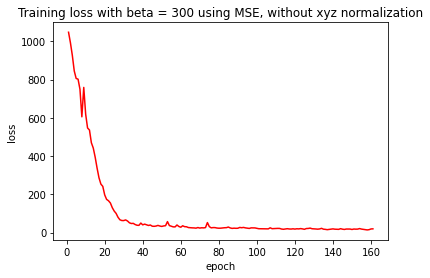

In [17]:
# plot the result trainning loss image
x_axix = range(1,162)
plt.title('Training loss with beta = 300 using MSE, without xyz normalization')
plt.plot(x_axix, train_loss, color='red')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('./result_image/result.png')
plt.show()


## Step 2: Testing

In [15]:
def get_accuracy(pred_xyz, pred_wpqr, poses_gt):
    pose_xyz = poses_gt[0:3]
    pose_wpqr = poses_gt[3:]

    # Calculate position and rotation error
    q1 = pose_wpqr / np.linalg.norm(pose_wpqr)
    q2 = pred_wpqr / np.linalg.norm(pred_wpqr)
    d = abs(np.sum(np.multiply(q1, q2)))
    theta = 2 * np.arccos(d) * 180 / np.pi
    error_x = np.linalg.norm(pose_xyz - pred_xyz)

    return error_x, theta

def test(epoch, data_dir):
    # test dataset and test loader
    datasource = DataSource(data_dir, train=False)
    test_loader = Data.DataLoader(dataset=datasource, batch_size=batch_size, shuffle=True)
    results = np.zeros((len(test_loader.dataset), 2))

    # load model
    posenet = PoseNet().to(device)

    save_filename = 'epoch_{}.pth'.format(str(161).zfill(5))
    save_path = os.path.join('checkpoints', save_filename)
    posenet.load_state_dict(torch.load(save_path))
    print("Checkpoint {} loaded!".format(save_filename))


    with torch.no_grad():
        posenet.eval()
        for step, (images, poses) in enumerate(test_loader):
            b_images = Variable(images).to(device)
            poses[0] = np.array(poses[0])
            poses[1] = np.array(poses[1])
            poses[2] = np.array(poses[2])
            poses[3] = np.array(poses[3])
            poses[4] = np.array(poses[4])
            poses[5] = np.array(poses[5])
            poses[6] = np.array(poses[6])
            poses = np.transpose(poses)
            b_poses = Variable(torch.Tensor(poses)).to(device)

            p_xyz, p_wpqr = posenet(b_images)

            p_xyz_np = p_xyz.cpu().numpy()
            p_wpqr_np = p_wpqr.cpu().numpy()

            for i in range(b_poses.shape[0]):
                print("{}".format(step*batch_size+i))
                print("GT\t| xyz: {}\twpqr: {}".format(poses[i,:3], poses[i, 3:]))
                print("PRED\t| xyz: {}\twpqr: {}".format(p_xyz_np[i], p_wpqr_np[i]))

                pos_error, ori_error = get_accuracy(p_xyz_np[i], p_wpqr_np[i], poses[i])
                results[step*batch_size+i, :] = [pos_error, ori_error]
                print("ACC\t| pos: {} m \tori: {} degrees".format(pos_error, ori_error))

        median_result = np.median(results, axis=0)
        mean_result = np.mean(results, axis=0)
        print("-----------------------------")
        print("Median position error: {} m \t Median orientation error: {} degrees".format(median_result[0], median_result[1]))
        print("Mean position error: {} m \t Mean orientation error: {} degrees".format(mean_result[0], mean_result[1]))



In [16]:
epochs=1
data_dir='data/KingsCollege/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

test(epochs, data_dir)

Mean image loaded!
Loading pretrained InceptionV1 weights...
PoseNet model created!
Checkpoint epoch_00161.pth loaded!
0
GT	| xyz: [  8.920337 -22.738723   1.83457 ]	wpqr: [ 0.769459  0.613496 -0.129266  0.121845]
PRED	| xyz: [ 24.764223  -21.61016     1.4152006]	wpqr: [ 0.04904854  0.04379128  0.00971731 -0.00473796]
ACC	| pos: 15.889564184971823 m 	ori: 39.20730234215259 degrees
1
GT	| xyz: [ 61.670009 -35.964148   1.547626]	wpqr: [ 0.690417  0.646561  0.228059 -0.230807]
PRED	| xyz: [ 68.504524  -37.316353    1.4127353]	wpqr: [ 0.07807272  0.05458721  0.04012921 -0.01524824]
ACC	| pos: 6.9683033711454145 m 	ori: 25.721220368420294 degrees
2
GT	| xyz: [ 25.531671 -26.357883   1.756772]	wpqr: [ 0.794085  0.605601  0.048069 -0.019102]
PRED	| xyz: [ 45.882957  -29.443802    1.5625684]	wpqr: [ 0.03853884  0.03708537  0.02602736 -0.01676317]
ACC	| pos: 20.58483594486696 m 	ori: 55.726897642024014 degrees
3
GT	| xyz: [ 39.052885 -29.070675   1.786923]	wpqr: [ 0.70747   0.62946   0.201023 -

32
GT	| xyz: [ 84.697138 -44.48497    1.193427]	wpqr: [ 0.671273  0.604462  0.292785 -0.31352 ]
PRED	| xyz: [ 73.90198   -40.008934    1.9291124]	wpqr: [ 0.07106751  0.04204265  0.04756555 -0.04440187]
ACC	| pos: 11.709467132243685 m 	ori: 32.35623118965251 degrees
33
GT	| xyz: [-20.131545 -17.893094   1.482647]	wpqr: [ 0.667977  0.591507 -0.314736  0.323831]
PRED	| xyz: [ -9.310982  -20.349117    1.9519795]	wpqr: [0.0677538  0.0934092  0.00030249 0.06337172]
ACC	| pos: 11.105715303226773 m 	ori: 46.55024730773368 degrees
34
GT	| xyz: [ 41.045486 -30.682359   1.837153]	wpqr: [ 0.713186  0.657622  0.164026 -0.178871]
PRED	| xyz: [ 51.394817 -33.426975   1.938591]	wpqr: [ 0.06383457  0.04384929  0.04951148 -0.04021549]
ACC	| pos: 10.707561228834338 m 	ori: 53.28810518605065 degrees
35
GT	| xyz: [ -7.603774 -18.817994   1.954586]	wpqr: [ 0.717915  0.575522 -0.253223  0.29875 ]
PRED	| xyz: [  9.3170185 -21.250362    1.7391886]	wpqr: [0.07846154 0.08622762 0.003333   0.04087657]
ACC	| pos: 

64
GT	| xyz: [ 37.226719 -29.931789   1.602856]	wpqr: [ 0.7039    0.651743  0.167136 -0.227644]
PRED	| xyz: [ 49.191067 -31.486885   1.929997]	wpqr: [ 0.03447907  0.06067149  0.04100746 -0.03132672]
ACC	| pos: 12.06942259977922 m 	ori: 52.631158174241925 degrees
65
GT	| xyz: [ 22.182492 -25.816673   1.921312]	wpqr: [ 0.731982  0.65504   0.125468 -0.139222]
PRED	| xyz: [ 37.695587  -28.805172    1.8652235]	wpqr: [ 0.04329946  0.03859627  0.02057552 -0.01607985]
ACC	| pos: 15.798430092175632 m 	ori: 27.437856667504615 degrees
66
GT	| xyz: [ -7.707132 -20.059667   1.770922]	wpqr: [ 0.675097  0.617984 -0.293334  0.276213]
PRED	| xyz: [  7.5439324 -22.410221    1.9105384]	wpqr: [ 7.2734699e-02  8.0149516e-02 -6.5347180e-05  3.1825703e-02]
ACC	| pos: 15.43177124681848 m 	ori: 35.50083613513054 degrees
67
GT	| xyz: [-33.518579 -14.645796   1.648173]	wpqr: [ 0.656966  0.531542 -0.340899  0.411882]
PRED	| xyz: [-22.370071  -15.416914    1.5966494]	wpqr: [0.07445277 0.11844737 0.00079725 0.08414

96
GT	| xyz: [ 29.470839 -28.381274   1.747847]	wpqr: [ 0.771991  0.601384  0.10295  -0.178235]
PRED	| xyz: [ 25.563444 -29.991999   2.234751]	wpqr: [ 0.0619416   0.05206132 -0.013948    0.01295629]
ACC	| pos: 4.2543206359125545 m 	ori: 49.84862744098438 degrees
97
GT	| xyz: [-23.660958 -14.852443   1.744996]	wpqr: [ 0.627253  0.558269 -0.348565  0.416403]
PRED	| xyz: [ -9.776455  -17.475054    1.7174344]	wpqr: [ 0.10565515  0.11442353 -0.01191112  0.05433918]
ACC	| pos: 14.130048570600193 m 	ori: 36.7872364446415 degrees
98
GT	| xyz: [ 12.529689 -24.816962   1.796   ]	wpqr: [ 0.770357  0.631764 -0.05122   0.069288]
PRED	| xyz: [ 26.90625   -26.774006    1.8527521]	wpqr: [ 0.06144021  0.07309622  0.0237723  -0.0239436 ]
ACC	| pos: 14.509264205098395 m 	ori: 52.998803507256625 degrees
99
GT	| xyz: [ 21.092053 -26.727456   1.713237]	wpqr: [ 0.771927  0.633801  0.017929 -0.045863]
PRED	| xyz: [ 30.54639   -28.943083    1.9280335]	wpqr: [ 0.06077268  0.06967368  0.00791661 -0.01437955]
ACC

128
GT	| xyz: [ 11.137815 -23.26375    1.980607]	wpqr: [ 0.777863  0.624057 -0.055555  0.048954]
PRED	| xyz: [ 30.51253   -24.068142    1.5767659]	wpqr: [ 0.05539763  0.04312987  0.03221353 -0.04202449]
ACC	| pos: 19.395610097874677 m 	ori: 82.40888876311331 degrees
129
GT	| xyz: [ 60.767351 -36.188643   1.539174]	wpqr: [ 0.685343  0.66261   0.206066 -0.220884]
PRED	| xyz: [ 64.03452  -33.07749    1.435173]	wpqr: [ 0.05181706  0.05444213  0.05044682 -0.04763957]
ACC	| pos: 4.51270331197944 m 	ori: 50.53333043401202 degrees
130
GT	| xyz: [ -1.910129 -20.86295    1.822718]	wpqr: [ 0.749814  0.593862 -0.189459  0.221839]
PRED	| xyz: [ 17.010645  -20.507032    1.4253694]	wpqr: [ 0.04221662  0.05366474  0.00889941 -0.00197031]
ACC	| pos: 18.9282922822564 m 	ori: 53.91437803819524 degrees
131
GT	| xyz: [-22.332044 -17.311181   1.835565]	wpqr: [ 0.668366  0.593467 -0.326872  0.306984]
PRED	| xyz: [-13.379139  -19.721298    2.0633638]	wpqr: [0.07291213 0.12337352 0.01006577 0.06920907]
ACC	| p

160
GT	| xyz: [-11.624243 -19.338281   1.81468 ]	wpqr: [ 0.693521  0.622262 -0.240803  0.271722]
PRED	| xyz: [ -0.07831381 -20.643282     1.855255  ]	wpqr: [ 0.0742765   0.08211356 -0.00441961  0.04585782]
ACC	| pos: 11.619516115057916 m 	ori: 28.893869492515066 degrees
161
GT	| xyz: [ 18.487009 -24.596167   1.877998]	wpqr: [ 0.751006  0.650286  0.085662 -0.076031]
PRED	| xyz: [ 37.68872   -26.389175    1.5039558]	wpqr: [ 0.06233495  0.03305199  0.0314503  -0.02988446]
ACC	| pos: 19.288870341287215 m 	ori: 55.581157155018374 degrees
162
GT	| xyz: [-29.97505  -15.670871   1.755439]	wpqr: [ 0.63689   0.577201 -0.348815  0.373548]
PRED	| xyz: [-20.66326  -18.830666   2.001929]	wpqr: [0.07776795 0.14334086 0.02237249 0.08511768]
ACC	| pos: 9.836386601940976 m 	ori: 65.03628348203834 degrees
163
GT	| xyz: [-20.134839 -16.64177    1.735459]	wpqr: [ 0.672315  0.574745 -0.296687  0.360053]
PRED	| xyz: [-10.335485  -18.184954    1.8221195]	wpqr: [ 0.05979886  0.09107007 -0.01987397  0.07858193]

192
GT	| xyz: [-11.531299 -18.548329   1.807577]	wpqr: [ 0.685505  0.565523 -0.301249  0.34571 ]
PRED	| xyz: [ -1.0165339 -20.799486    1.8840998]	wpqr: [0.08424805 0.10396516 0.01020222 0.03061073]
ACC	| pos: 10.753318112610518 m 	ori: 51.35638575657655 degrees
193
GT	| xyz: [-13.182436 -18.442966   1.724784]	wpqr: [ 0.678307  0.569025 -0.308146  0.348075]
PRED	| xyz: [ -0.06125604 -21.941763     1.9513699 ]	wpqr: [0.06826221 0.08940864 0.007884   0.04329877]
ACC	| pos: 13.581542052594722 m 	ori: 49.217479010399884 degrees
194
GT	| xyz: [ -5.101734 -19.098551   1.921939]	wpqr: [ 0.677377  0.652143 -0.223851  0.256438]
PRED	| xyz: [ 19.551756  -20.398136    1.5120202]	wpqr: [0.05231744 0.06338754 0.00277461 0.00279871]
ACC	| pos: 24.691122279767875 m 	ori: 41.78803836604411 degrees
195
GT	| xyz: [ 59.48064  -34.301409   1.546711]	wpqr: [ 0.677551  0.603757  0.259558 -0.3302  ]
PRED	| xyz: [ 73.398125  -36.977955    1.4919906]	wpqr: [ 0.0556823   0.05466518  0.01998855 -0.01356492]
ACC	

224
GT	| xyz: [  1.329111 -21.285416   1.849226]	wpqr: [ 0.744088  0.599272 -0.205412  0.212159]
PRED	| xyz: [ 25.717426  -24.853258    1.6910365]	wpqr: [ 0.04953438  0.04720794  0.01500393 -0.01293945]
ACC	| pos: 24.64841667510965 m 	ori: 67.24109053524825 degrees
225
GT	| xyz: [-18.482603 -18.064309   1.507602]	wpqr: [ 0.665905  0.594171 -0.320936  0.317066]
PRED	| xyz: [ -9.528584  -20.541788    2.0036664]	wpqr: [ 0.08312364  0.10497799 -0.00302822  0.06004502]
ACC	| pos: 9.303679235471177 m 	ori: 40.43376073385162 degrees
226
GT	| xyz: [ 31.890466 -22.265945   1.830871]	wpqr: [ 0.721809  0.636428  0.172512 -0.210217]
PRED	| xyz: [ 49.302795  -27.656492    1.4528884]	wpqr: [ 0.04023698  0.05574109  0.0197404  -0.02361526]
ACC	| pos: 18.231568386479807 m 	ori: 29.210222632744888 degrees
227
GT	| xyz: [-37.579731 -15.826912   1.658315]	wpqr: [ 0.63028   0.538737 -0.365744  0.422778]
PRED	| xyz: [-27.528189  -16.295586    1.4467057]	wpqr: [0.03999772 0.15958321 0.00386431 0.11555634]
A

256
GT	| xyz: [ 43.612879 -31.13164    2.058776]	wpqr: [ 0.69658   0.677056  0.157951 -0.177265]
PRED	| xyz: [ 52.77295   -31.573463    1.3966709]	wpqr: [ 0.06185343  0.03912095  0.03911534 -0.02364584]
ACC	| pos: 9.194589576389474 m 	ori: 44.21576330988817 degrees
257
GT	| xyz: [-17.040541 -18.506951   1.386512]	wpqr: [ 0.672125  0.603369 -0.322315  0.283384]
PRED	| xyz: [ -6.412454  -20.612934    1.9012651]	wpqr: [ 0.08426828  0.09702976 -0.01595419  0.06179834]
ACC	| pos: 10.846951932367679 m 	ori: 32.26913801877855 degrees
258
GT	| xyz: [ 95.31596  -43.556121   0.429182]	wpqr: [ 0.62343   0.587391  0.31339  -0.409992]
PRED	| xyz: [ 81.44279   -37.9821      1.0149965]	wpqr: [ 0.09031395  0.0683577   0.06470468 -0.05612264]
ACC	| pos: 14.962546476856508 m 	ori: 20.478912547583334 degrees
259
GT	| xyz: [ 24.217606 -27.321169   1.67385 ]	wpqr: [ 0.767494  0.621492  0.102499 -0.119143]
PRED	| xyz: [ 36.64673   -31.452637    1.7534301]	wpqr: [ 0.06767762  0.05947545  0.02684847 -0.022222

288
GT	| xyz: [ -7.08759  -18.692583   2.015063]	wpqr: [ 0.68151   0.63472  -0.246317  0.268332]
PRED	| xyz: [ 11.44329   -20.014027    1.7146987]	wpqr: [0.0411842  0.04920029 0.00634133 0.02782047]
ACC	| pos: 18.580364274900052 m 	ori: 43.60108569389265 degrees
289
GT	| xyz: [-34.5983   -15.14556    1.659762]	wpqr: [ 0.624355  0.549608 -0.362906  0.420013]
PRED	| xyz: [-28.133553  -15.389983    1.8900431]	wpqr: [ 0.05964828  0.1516945  -0.01018971  0.12852725]
ACC	| pos: 6.473463653145997 m 	ori: 61.83664445156692 degrees
290
GT	| xyz: [-12.43157  -19.402619   1.431984]	wpqr: [ 0.704001  0.610005 -0.241154  0.27225 ]
PRED	| xyz: [ -1.6197777 -20.900873    1.9193097]	wpqr: [ 0.0671804   0.06760417 -0.00253951  0.04216507]
ACC	| pos: 10.925983029257209 m 	ori: 30.300162901669044 degrees
291
GT	| xyz: [ 38.699098 -30.202205   1.606922]	wpqr: [ 0.694258  0.662791  0.170909 -0.222495]
PRED	| xyz: [ 51.99195   -34.525444    1.9195486]	wpqr: [0.03514357 0.06172905 0.03002687 0.01339726]
ACC	

320
GT	| xyz: [-21.643557 -17.674844   1.581228]	wpqr: [ 0.66431   0.594005 -0.326603  0.314929]
PRED	| xyz: [-13.263098  -19.061321    1.7371259]	wpqr: [0.07115044 0.12222616 0.01251123 0.07594854]
ACC	| pos: 8.495806045186766 m 	ori: 59.633607111697806 degrees
321
GT	| xyz: [ 34.250713 -28.284919   1.820037]	wpqr: [ 0.691678  0.657593  0.214038 -0.208187]
PRED	| xyz: [ 47.902817  -33.946598    1.9622488]	wpqr: [0.03939247 0.04629206 0.03526773 0.01910762]
ACC	| pos: 14.780215536644203 m 	ori: 65.47287819738041 degrees
322
GT	| xyz: [-32.151277 -14.286741   1.375209]	wpqr: [ 0.655395  0.538127 -0.339799  0.406712]
PRED	| xyz: [-22.712536  -15.006369    1.5205637]	wpqr: [0.0611813  0.13929397 0.00364606 0.10477732]
ACC	| pos: 9.467250196014424 m 	ori: 64.30061466152176 degrees
323
GT	| xyz: [ -8.413352 -18.817093   1.798918]	wpqr: [ 0.708845  0.584995 -0.259047  0.297008]
PRED	| xyz: [  6.4458237 -21.013763    1.8313667]	wpqr: [0.06863368 0.06559806 0.00660637 0.02725415]
ACC	| pos: 15